In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import seaborn as sns

In [3]:
# Chaospy RULE VALIDITY CHECK FUNCTION
# Highly likely some rules in chaospy are not properly implemented and buggy
def check_quadrature_rules(joint_distribution, rules=None, orders=[1, 2], unity_tol = 1e-4, weight_ratio = 1e4):
    """
    Perform checks for quadrature rules on given joint distribution for specified orders.

    :param joint_distribution: A joint probability distribution created using chaospy.
    :param rules: List of quadrature rules expressed as strings. Defaults to the specified list of rules.
    :param orders: List of orders for sparse grids. Defaults to [1, 2].
    """
    # Default list of rules, if not provided
    if rules is None:
        rules = [
            "clenshaw_curtis", "fejer_1", "fejer_2", "gaussian",
            "legendre", "lobatto", "kronrod", "patterson",
            "radau", "leja", "newton_cotes", "genz_keister_16",
            "genz_keister_18", "genz_keister_22", "genz_keister_24"
        ]

    # Dictionary to store valid rules for each order
    valid_rules_dict = {}

    # Loop over the orders and rules and generate quadrature weights
    for order in orders:
        print(f"\nOrder: {order}")
        valid_rules = []
        nan_weight_rules = []
        negative_weight_rules = []
        sum_weight_rules = []
        high_ratio_rules = []

        for rule in rules:
            try:
                nodes, weights = cp.generate_quadrature(order, dist=joint_distribution, rule=rule)

                # Check for nan weights
                if np.any(np.isnan(weights)):
                    nan_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check non-negativity
                if any(weight < 0 for weight in weights):
                    negative_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check sum of weights
                if not np.isclose(sum(weights), 1, rtol=unity_tol):
                    sum_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check ratio of max to min weights
                min_weight = min(weights)
                if min_weight == 0 or max(weights) / min_weight > weight_ratio:
                    high_ratio_rules.append(rule)
                    continue  # Skip to the next iteration

                # If all checks are passed, append the rule to the valid_rules list
                valid_rules.append(rule)

            except Exception as e:
                # Optionally, handle exceptions if needed
                print(f"Error with rule {rule}: {e}")  # For now, print the error and pass to the next iteration

        # Print the lists for the current order
        print("Valid Rules:", valid_rules)
        print("Rules with nan weights:", nan_weight_rules)
        print("Rules with negative weights:", negative_weight_rules)
        print("Rules where weights do not sum to 1:", sum_weight_rules)
        print("Rules with high max/min weight ratio:", high_ratio_rules)

        # Store the valid rules for the current order in the dictionary
        valid_rules_dict[order] = valid_rules

    return valid_rules_dict

GENERATE INPUT DISTRIBUTIONS

In [4]:
# Distribution Parameters
np.random.seed(1)
#hard material: steel
#soft material: nylon 6

E_s_mean = 200e6
# E_s_range = 100e6
E_s_std = E_s_mean*0.08
E_h_mean = 200e9
# E_h_range = 100e9
E_h_std = E_h_mean*0.02

rho_s_mean = 1e3
#rho_s_range = 5e2
rho_s_std = rho_s_mean*0.08
rho_h_mean = 8e3
#rho_h_range = 4e3
rho_h_std = rho_h_mean*0.02

pr_s_mean = 0.38
#pr_s_range = 0.25
pr_s_std = pr_s_mean*0.02
pr_h_mean = 0.28
#pr_h_range = 0.25
pr_h_std = pr_h_mean*0.02

geo_fp_mean = 0.025
geo_fp_std = geo_fp_mean*0.08

#Create Gaussian Distributions
E_soft_dist = cp.Normal(E_s_mean, E_s_std)
E_hard_dist = cp.Normal(E_h_mean, E_h_std)
rho_soft_dist = cp.Normal(rho_s_mean, rho_s_std)
rho_hard_dist = cp.Normal(rho_h_mean, rho_h_std)
pr_soft_dist = cp.Normal(pr_s_mean, pr_s_std)
pr_hard_dist = cp.Normal(pr_h_mean, pr_h_std)
geo_fp_dist = cp.Normal(geo_fp_mean, geo_fp_std)
joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist, geo_fp_dist)

Text(0.5, 0.98, 'Histograms of 100 MC samples OF 6+1D Input Space - Truncated Gaussian Distributions')

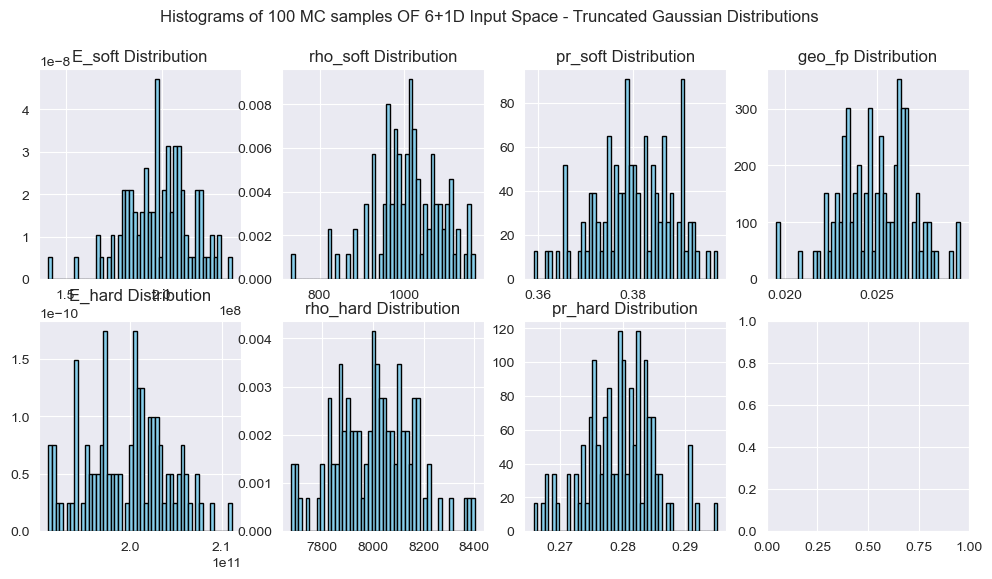

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(E_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('E_soft Distribution')

axes[1, 0].hist(E_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('E_hard Distribution')

axes[0, 1].hist(rho_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('rho_soft Distribution')

axes[1, 1].hist(rho_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('rho_hard Distribution')

axes[0, 2].hist(pr_soft_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('pr_soft Distribution')

axes[1, 2].hist(pr_hard_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('pr_hard Distribution')

axes[0, 3].hist(geo_fp_dist.sample(size=100), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp Distribution')

title_str = 'Histograms of 100 MC samples OF 6+1D Input Space - Truncated Gaussian Distributions'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Histograms of 1000 MC samples OF 6+1D Input Space - Truncated Gaussian Distributions')

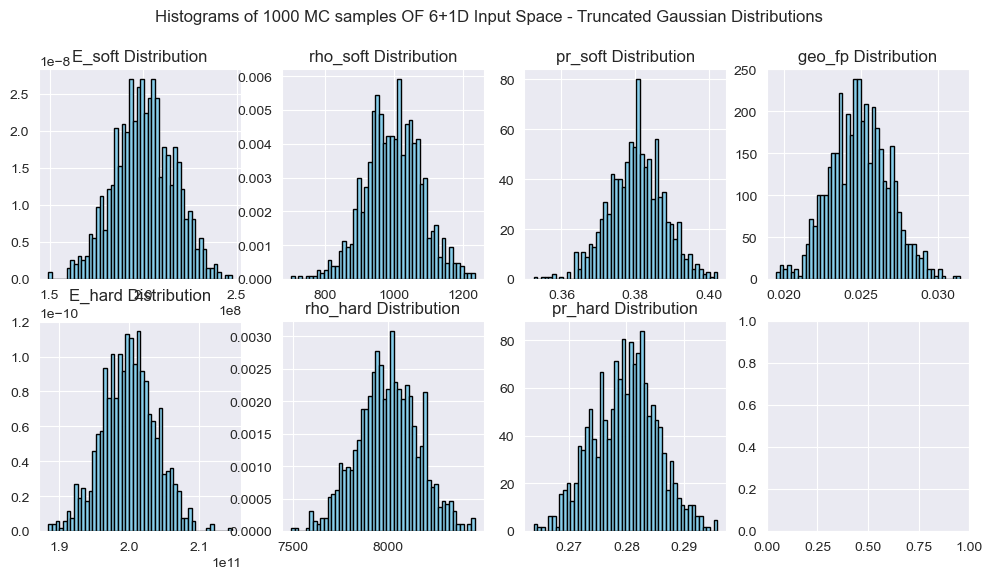

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(E_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('E_soft Distribution')

axes[1, 0].hist(E_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('E_hard Distribution')

axes[0, 1].hist(rho_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('rho_soft Distribution')

axes[1, 1].hist(rho_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('rho_hard Distribution')

axes[0, 2].hist(pr_soft_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('pr_soft Distribution')

axes[1, 2].hist(pr_hard_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('pr_hard Distribution')

axes[0, 3].hist(geo_fp_dist.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp Distribution')

title_str = 'Histograms of 1000 MC samples OF 6+1D Input Space - Truncated Gaussian Distributions'
fig.suptitle(title_str)

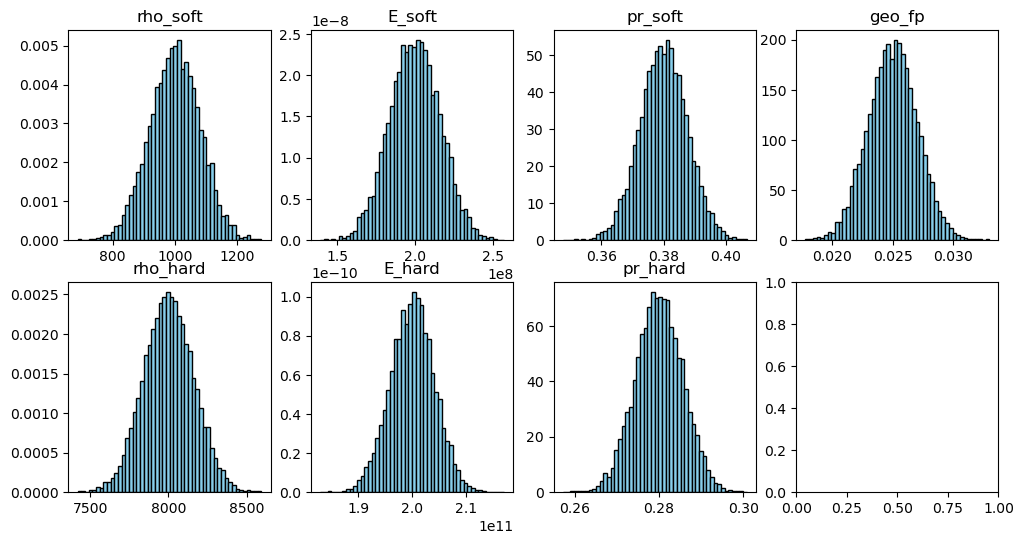

In [7]:
plt.style.use('default')

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plotting the distributions
axes[0, 0].hist(rho_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('rho_soft')
axes[0, 0].set_facecolor('none')

axes[1, 0].hist(rho_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('rho_hard')
axes[1, 0].set_facecolor('none')

axes[0, 1].hist(E_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('E_soft')
axes[0, 1].set_facecolor('none')

axes[1, 1].hist(E_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('E_hard')
axes[1, 1].set_facecolor('none')

axes[0, 2].hist(pr_soft_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 2].set_title('pr_soft')
axes[0, 2].set_facecolor('none')

axes[1, 2].hist(pr_hard_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 2].set_title('pr_hard')
axes[1, 2].set_facecolor('none')

axes[0, 3].hist(geo_fp_dist.sample(size=10000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 3].set_title('geo_fp')
axes[0, 3].set_facecolor('none')

axes[1, 3].set_facecolor('none')

# for ax in axes.ravel():
#     xticks = ax.get_xticks()
#     ax.set_xticks(xticks[::3])
#
#     yticks = ax.get_yticks()
#     ax.set_yticks(yticks[::2])

# title_str = 'Histograms of 10000 MC samples OF 6+1D Input Space - Truncated Gaussian Distributions'
# fig.suptitle(title_str)

In [8]:
#Create truncated variants of Gaussian distributions
E_soft_dist_trunc = cp.TruncNormal(lower=E_s_mean-4*E_s_std, upper=E_s_mean+4*E_s_std, mu=E_s_mean, sigma=E_s_std)
E_hard_dist_trunc = cp.TruncNormal(lower=E_h_mean-4*E_h_std, upper=E_h_mean+4*E_h_std, mu=E_h_mean, sigma=E_h_std)
rho_soft_dist_trunc = cp.TruncNormal(lower=rho_s_mean-4*rho_s_std, upper=rho_s_mean+4*rho_s_std, mu=rho_s_mean, sigma=rho_s_std)
rho_hard_dist_trunc = cp.TruncNormal(lower=rho_h_mean-4*rho_h_std, upper=rho_h_mean+4*rho_h_std, mu=rho_h_mean, sigma=rho_h_std)
pr_soft_dist_trunc = cp.TruncNormal(lower=pr_s_mean-4*pr_s_std, upper=pr_s_mean+4*pr_s_std, mu=pr_s_mean, sigma=pr_s_std)
pr_hard_dist_trunc = cp.TruncNormal(lower=pr_h_mean-4*pr_h_std, upper=pr_h_mean+4*pr_h_std, mu=pr_h_mean, sigma=pr_h_std)
geo_fp_dist_trunc = cp.TruncNormal(lower=geo_fp_mean-4*geo_fp_std, upper=geo_fp_mean+4*geo_fp_std, mu=geo_fp_mean, sigma=geo_fp_std)
joint_dist_trunc = cp.J(E_soft_dist_trunc, E_hard_dist_trunc, rho_soft_dist_trunc, rho_hard_dist_trunc, pr_soft_dist_trunc, pr_hard_dist_trunc, geo_fp_dist_trunc)

Text(0.5, 1.0, 'geo_fp Distribution')

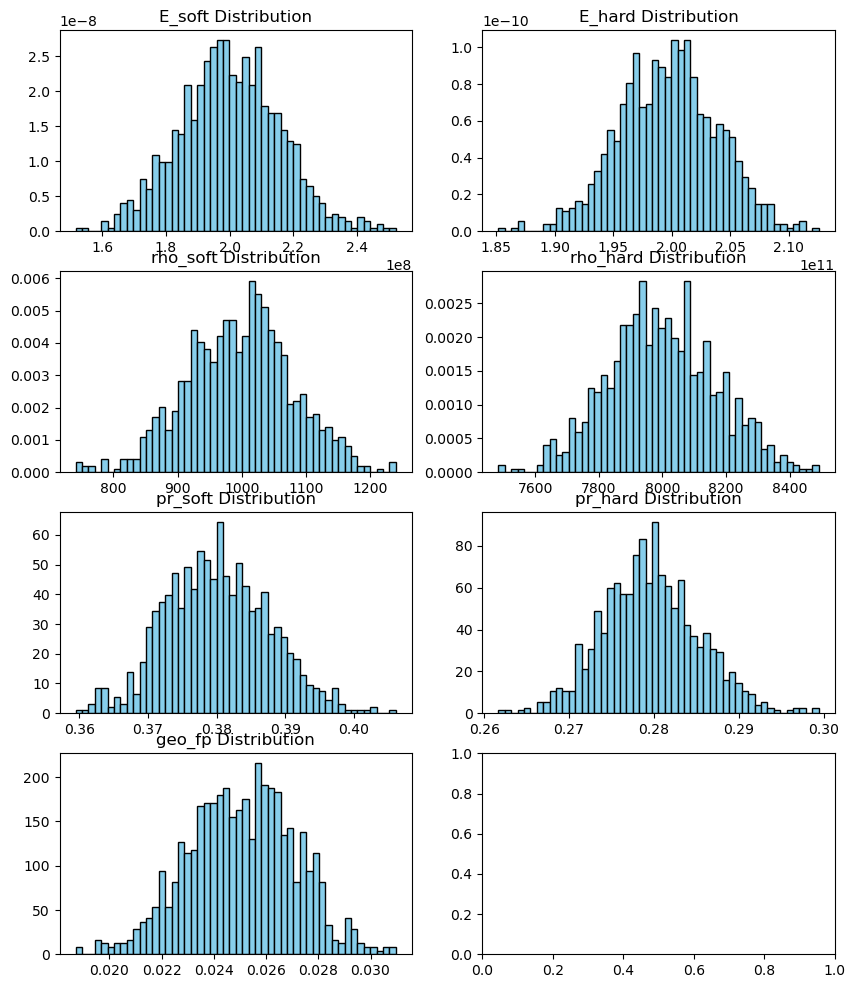

In [9]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 12))

# Plotting the distributions
axes[0, 0].hist(E_soft_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('E_soft Distribution')

axes[0, 1].hist(E_hard_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[0, 1].set_title('E_hard Distribution')

axes[1, 0].hist(rho_soft_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 0].set_title('rho_soft Distribution')

axes[1, 1].hist(rho_hard_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[1, 1].set_title('rho_hard Distribution')

axes[2, 0].hist(pr_soft_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[2, 0].set_title('pr_soft Distribution')

axes[2, 1].hist(pr_hard_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[2, 1].set_title('pr_hard Distribution')

axes[3, 0].hist(geo_fp_dist_trunc.sample(size=1000), bins=50, density=True, color='skyblue', edgecolor='black')
axes[3, 0].set_title('geo_fp Distribution')

In [10]:
### GENERATE QUADRATURE RULE SAMPLES ###
degrees = [1, 2, 3]
#computation points = (degree+1)**(input dimensions)
quadrature_surrogates = {}
quadrature_nodes = {}
quadrature_weights = {}
for d in degrees:
    #nodes, weights = cp.generate_quadrature(d, joint_dist, rule='G')
    nodes, weights = cp.generate_quadrature(d, joint_dist_trunc, rule='G')
    #nodes, weights = cp.quadrature.legendre(order=d, lower=E_soft_dist.lower, upper=E_soft_dist.upper)
    quadrature_nodes[d] = nodes
    quadrature_weights[d] = weights
#quadrature_nodes

for qd in quadrature_nodes:
    #savemat('joint_dist_mat_geo_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_nodes[qd]})
    savemat('joint_dist_mat_geo_trunc_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_inputs':quadrature_nodes[qd]})
    savemat('geo_dist_trunc_pd_'+str(qd)+'.mat',{'pd_'+str(qd)+'_geos':quadrature_nodes[qd][6]})

print(np.mean(quadrature_nodes[1][6]))

0.025


In [11]:
valid_rules = check_quadrature_rules(joint_dist, orders=[1, 2])


Order: 1
Valid Rules: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'newton_cotes']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['kronrod', 'patterson', 'radau', 'leja', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']

Order: 2
Valid Rules: ['leja']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'kronrod', 'patterson', 'radau', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']


In [12]:
### GENERATE SPARSE GRID QUADRATURE RULE SAMPLES ###
sparse_degrees = [1,2,3]
# For Smolyak sparse grids, computation points won't necessarily be (degree+1)**(input dimensions)
sparse_surrogates = {}
sparse_nodes = {}
sparse_weights = {}

for d in sparse_degrees:
    nodes, weights = cp.sparse_grid(order=d, dist=joint_dist_trunc, recurrence_algorithm='stieltjes', rule='gaussian', growth=False)
    sparse_nodes[d] = nodes
    sparse_weights[d] = weights

for qd in sparse_nodes:
    savemat('joint_dist_mat_geo_pd_'+str(qd)+'_sparse.mat', {'pd_'+str(qd)+'_inputs': sparse_nodes[qd]})
    savemat('geo_dist_gauss_trunc_pd_'+str(qd)+'_sparse.mat', {'pd_'+str(qd)+'_geos': sparse_nodes[qd][6]})

print(np.mean(sparse_nodes[1][6]))
# print(sparse_nodes[3].shape)
# print(sparse_weights[3].shape)
# print(sparse_nodes[1])
# print(sparse_weights[1])

0.025000000000000012


In [13]:
### GENERATE MONTE CARLO INPUT SAMPLES ###
N_MC2 = 100
N_MC3 = 1000
N_MC4 = 10000

joint_samples_MC2 = joint_dist_trunc.sample(N_MC2)
joint_samples_MC3 = joint_dist_trunc.sample(N_MC3)
joint_samples_MC4 = joint_dist_trunc.sample(N_MC4)

savemat('joint_dist_trunc_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_inputs':joint_samples_MC2})
savemat('joint_dist_trunc_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_inputs':joint_samples_MC3})
savemat('joint_dist_trunc_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_inputs':joint_samples_MC4})

In [14]:
print(joint_samples_MC2.shape)
print(joint_samples_MC2[-1::].shape)
geo_fp_dist_trunc_MC2 = joint_samples_MC2[-1::]
geo_fp_dist_trunc_MC3 = joint_samples_MC3[-1::]
geo_fp_dist_trunc_MC4 = joint_samples_MC4[-1::]

savemat('geo_fp_dist_trunc_mc_'+str(N_MC2)+'.mat',{'mc_'+str(N_MC2)+'_geos':geo_fp_dist_trunc_MC2})
savemat('geo_fp_dist_trunc_mc_'+str(N_MC3)+'.mat',{'mc_'+str(N_MC3)+'_geos':geo_fp_dist_trunc_MC3})
savemat('geo_fp_dist_trunc_mc_'+str(N_MC4)+'.mat',{'mc_'+str(N_MC4)+'_geos':geo_fp_dist_trunc_MC4})

(7, 100)
(1, 100)


QUADRATURE INPUT DISTRIBUTIONS GENERATED - MATLAB RUNS COMMENCE

LOAD QUADRATURE OUTPUTS

In [15]:
E_soft_sample_sets = {}
E_hard_sample_sets = {}
rho_soft_sample_sets = {}
rho_hard_sample_sets = {}
pr_soft_sample_sets = {}
pr_hard_sample_sets = {}
geo_fp_sample_sets = {}
bg_size_sample_sets = {}
bg_top_sample_sets = {}
bg_bottom_sample_sets = {}
bg_center_sample_sets = {}

for d in degrees:
    folder_name = 'gaussian 6+1 inputs quadrature rule 2nd geo study'#+str(d)
    #file_suffix = '_q_pd'+str(d)+'_uniform_'+str((d+1)**6)+'.mat'
    file_suffix ='_gaussian_7d_fp_5%_n'+str((d+1)**7)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    rho_soft_sample_sets[d] = rho_soft_file['rho_soft'][:]
    rho_hard_sample_sets[d] = rho_hard_file['rho_hard'][:]
    pr_soft_sample_sets[d] = pr_soft_file['pr_soft'][:]
    pr_hard_sample_sets[d] = pr_hard_file['pr_hard'][:]

    bg_size_sample_sets[d] = bg_size_file['bg_size'][:]
    bg_top_sample_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_sample_sets[d] = bg_bottom_file['bg_bottom'][:]
    bg_center_sample_sets[d] = (bg_top_sample_sets[d]+bg_bottom_sample_sets[d])/2

LOAD SPARSE GRID OUTPUTS

In [16]:
rho_soft_SG_sets = {}
rho_hard_SG_sets = {}
K_soft_SG_sets = {}
K_hard_SG_sets = {}
G_soft_SG_sets = {}
G_hard_SG_sets = {}
E_soft_SG_sets = {}
E_hard_SG_sets = {}
pr_soft_SG_sets = {}
pr_hard_SG_sets = {}
geo_fp_SG_sets = {}
bg_size_SG_sets = {}
bg_top_SG_sets = {}
bg_bottom_SG_sets = {}
bg_center_SG_sets = {}

sparse_degrees = [1]
d_n_map = {1:15}
for d in sparse_degrees:
    d_n_map[d] = int(sparse_weights[d].shape[0])
    folder_name = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    file_suffix ='_gaussian_7d_fp_5%_n'+str(d_n_map[d])+'.mat'

    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    # K_soft_file = loadmat(folder_name+'/K_soft'+file_suffix)
    # K_hard_file = loadmat(folder_name+'/K_hard'+file_suffix)
    # G_soft_file = loadmat(folder_name+'/G_soft'+file_suffix)
    # G_hard_file = loadmat(folder_name+'/G_hard'+file_suffix)
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    # rho_soft_SG_sets[d] = rho_soft_file['rho_soft'][:]
    # rho_hard_SG_sets[d] = rho_hard_file['rho_hard'][:]
    # K_soft_SG_sets[d] = K_soft_file['K_soft'][:]
    # K_hard_SG_sets[d] = K_hard_file['K_hard'][:]
    # G_soft_SG_sets[d] = G_soft_file['G_soft'][:]
    # G_hard_SG_sets[d] = G_hard_file['G_hard'][:]
    # E_soft_SG_sets[d] = E_soft_file['E_soft'][:]
    # E_hard_SG_sets[d] = E_hard_file['E_hard'][:]
    # pr_soft_SG_sets[d] = pr_soft_file['pr_soft'][:]
    # pr_hard_SG_sets[d] = pr_hard_file['pr_hard'][:]

    bg_size_SG_sets[d] = bg_size_file['bg_size'][:]
    bg_top_SG_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_SG_sets[d] = bg_bottom_file['bg_bottom'][:]
    bg_center_SG_sets[d] = (bg_top_SG_sets[d]+bg_bottom_SG_sets[d])/2

    # mat_geo_dist_file = loadmat(folder_name+'/joint_dist_mat_geo_pd_'+str(d)+'_sparse.mat')
    # rho_soft_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][0,:]
    # rho_hard_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][1,:]
    # K_soft_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][2,:]
    # K_hard_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][3,:]
    # G_soft_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][4,:]
    # G_hard_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][5,:]
    # geo_fp_SG_sets[d] = mat_geo_dist_file['pd_'+str(d)+'_inputs'][6,:]

LOAD MONTE CARLO OUTPUTS

In [17]:
E_soft_MC_sets = {}
E_hard_MC_sets = {}
rho_soft_MC_sets = {}
rho_hard_MC_sets = {}
pr_soft_MC_sets = {}
pr_hard_MC_sets = {}
geo_fp_MC_sets = {}
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}
bg_center_MC_sets = {}

set_N = [100, 1000, 10000]
for N in set_N:
    folder_name = 'gaussian 6+1 inputs mc 2nd geo study'#+str(N)
    #file_suffix = '_mc_uniform_'+str(N)+'.mat'
    file_suffix = '_gaussian_7d_fp_5%_n'+str(N)+'.mat'
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    rho_soft_file = loadmat(folder_name+'/rho_soft'+file_suffix)
    rho_hard_file = loadmat(folder_name+'/rho_hard'+file_suffix)
    pr_soft_file = loadmat(folder_name+'/pr_soft'+file_suffix)
    pr_hard_file = loadmat(folder_name+'/pr_hard'+file_suffix)
    geo_fp_file = loadmat(folder_name+'/geo_fp'+'_dist_trunc_mc_'+str(N)+'.mat')
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_soft_MC_sets[N] = E_soft_file['E_soft'][:]
    E_hard_MC_sets[N] = E_hard_file['E_hard'][:]
    rho_soft_MC_sets[N] = rho_soft_file['rho_soft'][:]
    rho_hard_MC_sets[N] = rho_hard_file['rho_hard'][:]
    pr_soft_MC_sets[N] = pr_soft_file['pr_soft'][:]
    pr_hard_MC_sets[N] = pr_hard_file['pr_hard'][:]
    geo_fp_MC_sets[N] = geo_fp_file['mc_'+str(N)+'_geos'][:].T
    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]
    bg_center_MC_sets[N] = (bg_top_MC_sets[N] + bg_bottom_MC_sets[N])/2

In [18]:
print(type(bg_center_sample_sets))
print(len(bg_center_sample_sets[3]))

print(type(bg_center_MC_sets))
print(len(bg_center_MC_sets[10000]))

print(type(geo_fp_MC_sets))
print(len(geo_fp_MC_sets[10000]))
print(geo_fp_MC_sets[1000].shape)
print(rho_hard_MC_sets[1000].shape)
# fig = plt.figure()
# plt.scatter(E_soft_sample_sets[2], bg_size_sample_sets[2])
# plt.title('Black Box Model Evaluations on 2th order quadrature samples')
# plt.xlabel('E_soft')
# plt.ylabel('bg_size')

<class 'dict'>
16384
<class 'dict'>
10000
<class 'dict'>
10000
(1000, 1)
(1000, 1)


Sparse grid fits on bandgap size

In [19]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sg_surrogates_bgs = {}
sparse_degrees = [1]
for degree in sparse_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(bg_size_SG_sets[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=bg_size_SG_sets[degree]
    )
    sg_surrogates_bgs[degree] = polynomial_approximation

(7, 15)
(15,)
(15, 1)


In [20]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 10000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs_sg_bgs = {}
surrogate_kdes_sg_bgs = {}
surrogate_pdf_sg_bgs = {}
for degree in sparse_degrees:
    surrogate_model = sg_surrogates_bgs[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs_sg_bgs[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes_sg_bgs[degree] = gaussian_kde(surrogate_outputs_sg_bgs[degree])
    surrogate_pdf_sg_bgs[degree] = surrogate_kdes_sg_bgs[degree](np.linspace(np.min(surrogate_outputs_sg_bgs[degree]), np.max(surrogate_outputs_sg_bgs[degree]), N_test))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_sg_bgs_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgs[degree]})
    savemat(save_folder+'/surrogate_kdes_sg_bgs_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_sg_bgs[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Size PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order 1 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

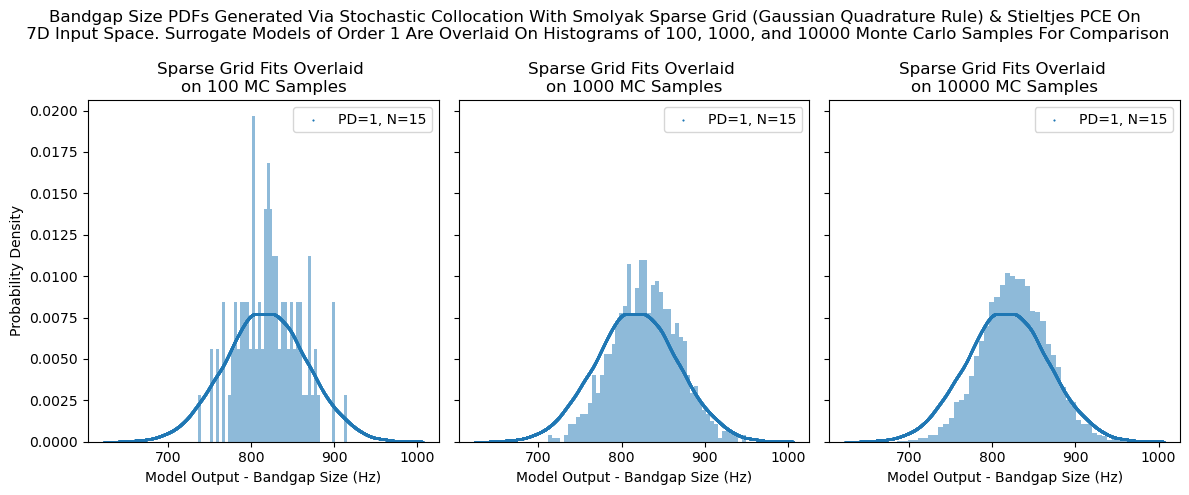

In [21]:
plt.style.use('default')
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in sparse_degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_SG_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_sg_bgs[d]), np.max(surrogate_outputs_sg_bgs[d]), N_test), surrogate_pdf_sg_bgs[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_sg_bgs[d]), np.max(surrogate_outputs_sg_bgs[d]), N_test), surrogate_pdf_sg_bgs[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_sg_bgs[d]), np.max(surrogate_outputs_sg_bgs[d]), N_test), surrogate_pdf_sg_bgs[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output - Bandgap Size (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Sparse Grid Fits Overlaid \non 100 MC Samples')

axs[1].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Sparse Grid Fits Overlaid \non 1000 MC Samples')

axs[2].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Sparse Grid Fits Overlaid \non 10000 MC Samples')

title_str = 'Bandgap Size PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order '+str(np.min(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Sparse grid fits on bandgap top

In [22]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sg_surrogates_bgt = {}
sparse_degrees = [1]
for degree in sparse_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(bg_top_SG_sets[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=bg_top_SG_sets[degree]
    )
    sg_surrogates_bgt[degree] = polynomial_approximation

(7, 15)
(15,)
(15, 1)


In [23]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 10000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs_sg_bgt = {}
surrogate_kdes_sg_bgt = {}
surrogate_pdf_sg_bgt = {}
for degree in sparse_degrees:
    surrogate_model = sg_surrogates_bgt[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs_sg_bgt[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes_sg_bgt[degree] = gaussian_kde(surrogate_outputs_sg_bgt[degree])
    surrogate_pdf_sg_bgt[degree] = surrogate_kdes_sg_bgt[degree](np.linspace(np.min(surrogate_outputs_sg_bgt[degree]), np.max(surrogate_outputs_sg_bgt[degree]), N_test))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_sg_bgt_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgt[degree]})
    savemat(save_folder+'/surrogate_kdes_sg_bgt_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_sg_bgt[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Top PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order 1 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

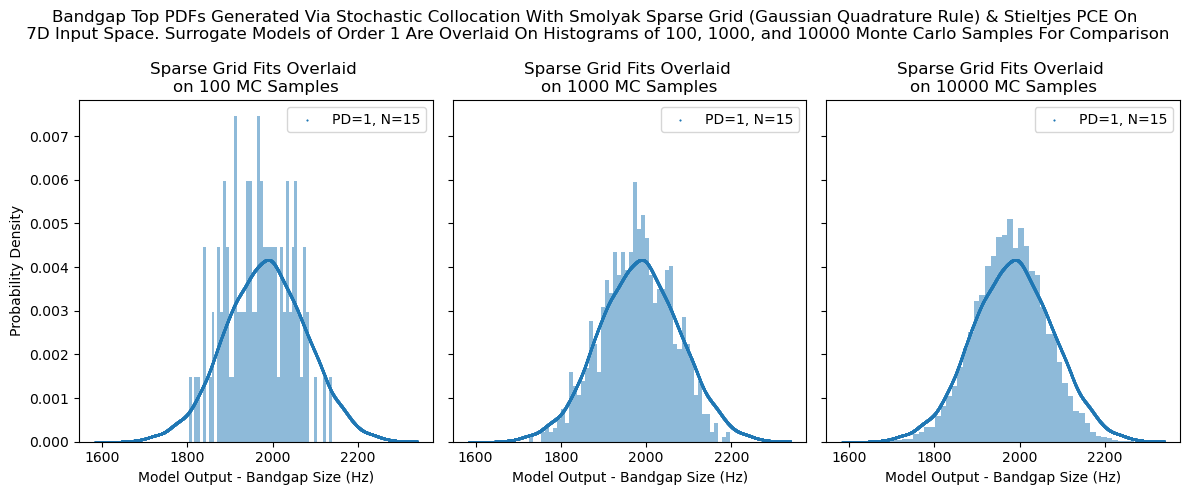

In [24]:
plt.style.use('default')
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in sparse_degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_top_SG_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_sg_bgt[d]), np.max(surrogate_outputs_sg_bgt[d]), N_test), surrogate_pdf_sg_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_sg_bgt[d]), np.max(surrogate_outputs_sg_bgt[d]), N_test), surrogate_pdf_sg_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_sg_bgt[d]), np.max(surrogate_outputs_sg_bgt[d]), N_test), surrogate_pdf_sg_bgt[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output - Bandgap Size (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Sparse Grid Fits Overlaid \non 100 MC Samples')

axs[1].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Sparse Grid Fits Overlaid \non 1000 MC Samples')

axs[2].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Sparse Grid Fits Overlaid \non 10000 MC Samples')

title_str = 'Bandgap Top PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order '+str(np.min(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Sparse grid fits on bandgap bottom

In [25]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sg_surrogates_bgb = {}
sparse_degrees = [1]
for degree in sparse_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(bg_bottom_SG_sets[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=bg_bottom_SG_sets[degree]
    )
    sg_surrogates_bgb[degree] = polynomial_approximation

(7, 15)
(15,)
(15, 1)


In [26]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 10000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs_sg_bgb = {}
surrogate_kdes_sg_bgb = {}
surrogate_pdf_sg_bgb = {}
for degree in sparse_degrees:
    surrogate_model = sg_surrogates_bgb[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs_sg_bgb[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes_sg_bgb[degree] = gaussian_kde(surrogate_outputs_sg_bgb[degree])
    surrogate_pdf_sg_bgb[degree] = surrogate_kdes_sg_bgb[degree](np.linspace(np.min(surrogate_outputs_sg_bgb[degree]), np.max(surrogate_outputs_sg_bgb[degree]), N_test))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_sg_bgb_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgb[degree]})
    savemat(save_folder+'/surrogate_kdes_sg_bgb_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_sg_bgb[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Bottom PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order 1 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

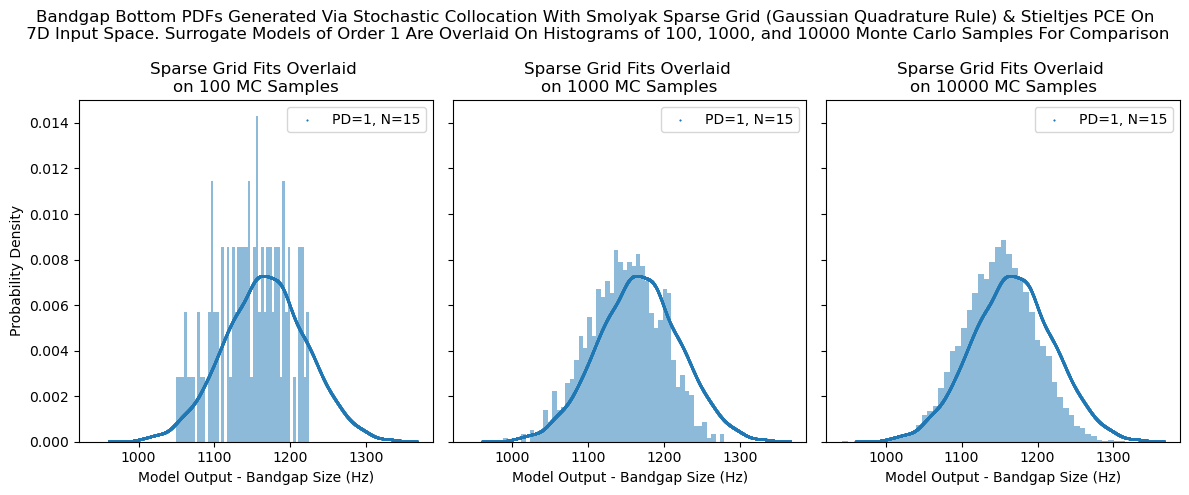

In [27]:
plt.style.use('default')
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in sparse_degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_bottom_SG_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_sg_bgb[d]), np.max(surrogate_outputs_sg_bgb[d]), N_test), surrogate_pdf_sg_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_sg_bgb[d]), np.max(surrogate_outputs_sg_bgb[d]), N_test), surrogate_pdf_sg_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_sg_bgb[d]), np.max(surrogate_outputs_sg_bgb[d]), N_test), surrogate_pdf_sg_bgb[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output - Bandgap Size (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Sparse Grid Fits Overlaid \non 100 MC Samples')

axs[1].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Sparse Grid Fits Overlaid \non 1000 MC Samples')

axs[2].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Sparse Grid Fits Overlaid \non 10000 MC Samples')

title_str = 'Bandgap Bottom PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order '+str(np.min(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Sparse grid fits on bandgap center

In [28]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sg_surrogates_bgc = {}
sparse_degrees = [1]
for degree in sparse_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(bg_center_SG_sets[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=bg_center_SG_sets[degree]
    )
    sg_surrogates_bgc[degree] = polynomial_approximation

(7, 15)
(15,)
(15, 1)


In [29]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 10000
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs_sg_bgc = {}
surrogate_kdes_sg_bgc = {}
surrogate_pdf_sg_bgc = {}
for degree in sparse_degrees:
    surrogate_model = sg_surrogates_bgc[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs_sg_bgc[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes_sg_bgc[degree] = gaussian_kde(surrogate_outputs_sg_bgc[degree])
    surrogate_pdf_sg_bgc[degree] = surrogate_kdes_sg_bgc[degree](np.linspace(np.min(surrogate_outputs_sg_bgc[degree]), np.max(surrogate_outputs_sg_bgc[degree]), N_test))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_sg_bgc_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgc[degree]})
    savemat(save_folder+'/surrogate_kdes_sg_bgc_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_sg_bgc[degree]})


(7, 10000)


Text(0.5, 0.98, 'Bandgap Center PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order 1 Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison')

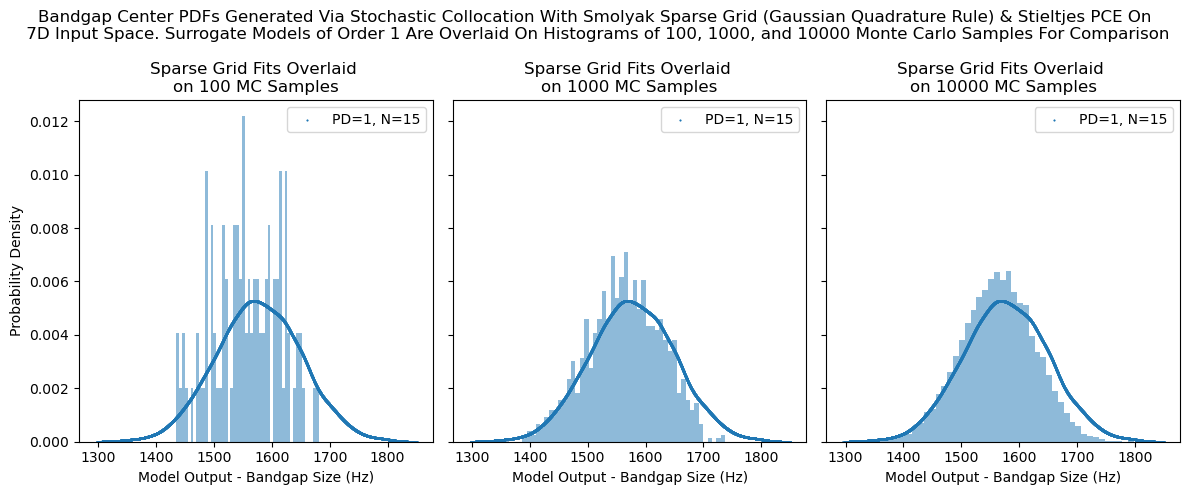

In [30]:
plt.style.use('default')
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in sparse_degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_center_SG_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_sg_bgc[d]), np.max(surrogate_outputs_sg_bgc[d]), N_test), surrogate_pdf_sg_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_sg_bgc[d]), np.max(surrogate_outputs_sg_bgc[d]), N_test), surrogate_pdf_sg_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_sg_bgc[d]), np.max(surrogate_outputs_sg_bgc[d]), N_test), surrogate_pdf_sg_bgc[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output - Bandgap Size (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Sparse Grid Fits Overlaid \non 100 MC Samples')

axs[1].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Sparse Grid Fits Overlaid \non 1000 MC Samples')

axs[2].set_xlabel("Model Output - Bandgap Size (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Sparse Grid Fits Overlaid \non 10000 MC Samples')

title_str = 'Bandgap Center PDFs Generated Via Stochastic Collocation With Smolyak Sparse Grid (Gaussian Quadrature Rule) & Stieltjes PCE On\n 7D Input Space. Surrogate Models of Order '+str(np.min(degrees))+' Are Overlaid On Histograms of 100, 1000, and 10000 Monte Carlo Samples For Comparison'
fig.suptitle(title_str)

Quadrature fits on bandgap size

In [31]:
### FIT SURROGATE MODELS - QUADRATURE RULE ###
q_surrogates_bgs = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist_trunc,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_size_sample_sets[degree]
    )
    q_surrogates_bgs[degree] = polynomial_approximation

In [32]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 10000
joint_test = joint_dist_trunc.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgs[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[degree] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs[degree] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:],
        q2=joint_test[2,:], q3=joint_test[3,:],
        q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[degree])
    surrogate_kdes[degree] = gaussian_kde(surrogate_outputs[degree])
    surrogate_pdf[degree] = surrogate_kdes[degree](np.linspace(np.min(surrogate_outputs[degree]), np.max(surrogate_outputs[degree]), N_test))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs quadrature rule 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_bgs_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs[degree]})
    savemat(save_folder+'/surrogate_kdes_bgs_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Size Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders 1 to 2 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

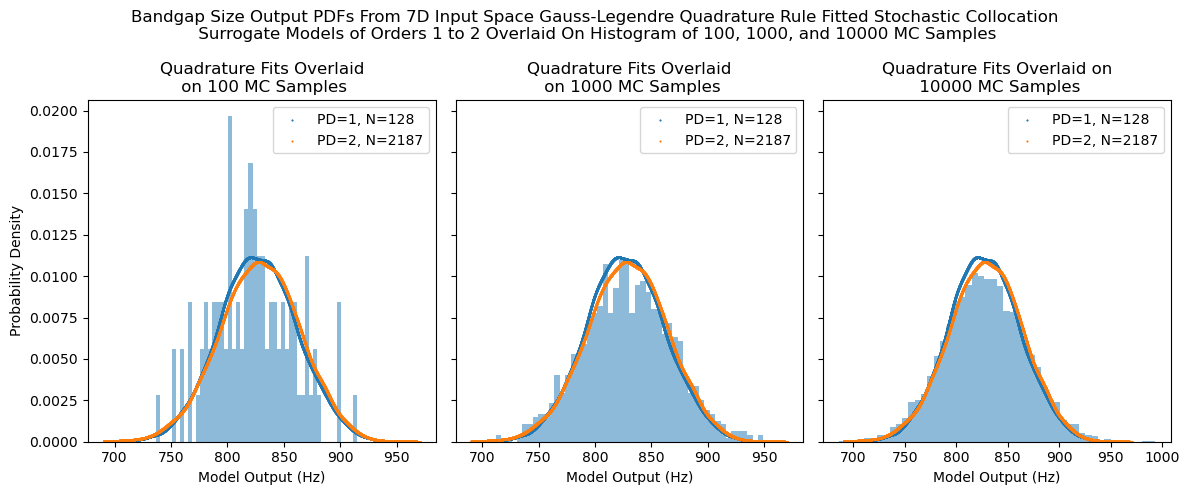

In [33]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)
degrees = [1,2]
# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), N_test), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), N_test), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), N_test), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid on\n 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap top

In [34]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP TOP ###
q_surrogates_bgt = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist_trunc,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_top_sample_sets[degree]
    )
    q_surrogates_bgt[degree] = polynomial_approximation

In [35]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgt = 10000
joint_test_bgt = joint_dist_trunc.sample(N_test_bgt)
print(joint_test_bgt.shape)
#print(joint_test_bgt[0])
surrogate_outputs_bgt = {}
surrogate_kdes_bgt = {}
surrogate_pdf_bgt = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgt[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgt[degree] = surrogate_model.__call__(joint_test_bgt).astype(float)
    surrogate_outputs_bgt[degree] = surrogate_model(
        q0=joint_test_bgt[0,:], q1=joint_test_bgt[1,:],
        q2=joint_test_bgt[2,:], q3=joint_test_bgt[3,:],
        q4=joint_test_bgt[4,:], q5=joint_test_bgt[5,:], q6=joint_test_bgt[6,:])
    #print(surrogate_outputs_bgt[degree])
    surrogate_kdes_bgt[degree] = gaussian_kde(surrogate_outputs_bgt[degree])
    surrogate_pdf_bgt[degree] = surrogate_kdes_bgt[degree](np.linspace(np.min(surrogate_outputs_bgt[degree]), np.max(surrogate_outputs_bgt[degree]), N_test_bgt))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs quadrature rule 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_bgt_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_bgt[degree]})
    savemat(save_folder+'/surrogate_kdes_bgt_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_bgt[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Top Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders 1 to 2 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

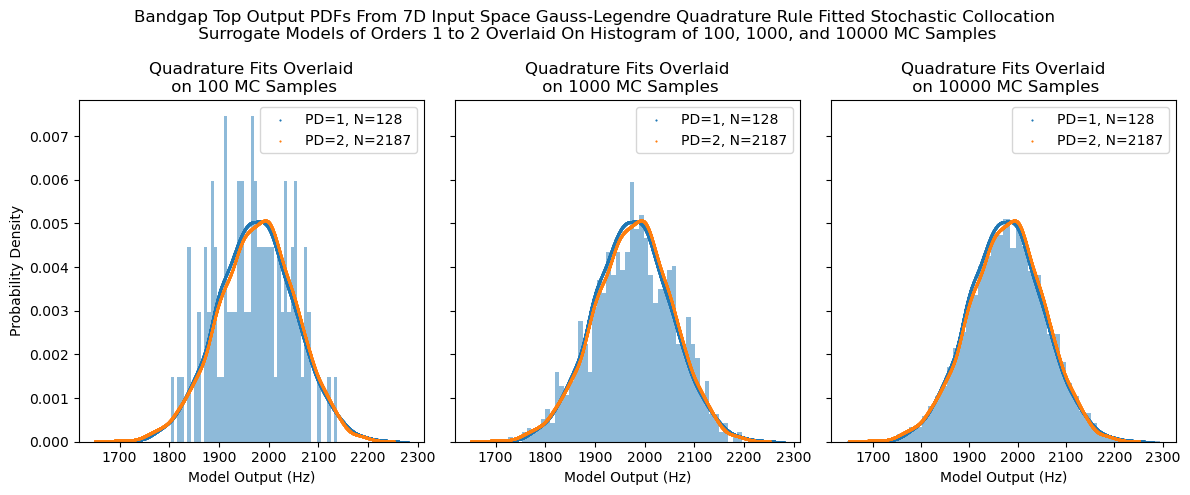

In [36]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), N_test_bgt), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), N_test_bgt), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgt[d]), np.max(surrogate_outputs_bgt[d]), N_test_bgt), surrogate_pdf_bgt[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap bottom

In [37]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP BOTTOM ###
q_surrogates_bgb = {}
for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist_trunc,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_bottom_sample_sets[degree]
    )
    q_surrogates_bgb[degree] = polynomial_approximation

In [38]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgb = 10000
joint_test_bgb = joint_dist_trunc.sample(N_test_bgb)
print(joint_test_bgb.shape)
#print(joint_test_bgb[0])
surrogate_outputs_bgb = {}
surrogate_kdes_bgb = {}
surrogate_pdf_bgb = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgb[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgb[degree] = surrogate_model.__call__(joint_test_bgb).astype(float)
    surrogate_outputs_bgb[degree] = surrogate_model(
        q0=joint_test_bgb[0,:], q1=joint_test_bgb[1,:],
        q2=joint_test_bgb[2,:], q3=joint_test_bgb[3,:],
        q4=joint_test_bgb[4,:], q5=joint_test_bgb[5,:], q6=joint_test_bgb[6,:])
    #print(surrogate_outputs_bgb[degree])
    surrogate_kdes_bgb[degree] = gaussian_kde(surrogate_outputs_bgb[degree])
    surrogate_pdf_bgb[degree] = surrogate_kdes_bgb[degree](np.linspace(np.min(surrogate_outputs_bgb[degree]), np.max(surrogate_outputs_bgb[degree]), N_test_bgb))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs quadrature rule 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_bgb_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_bgb[degree]})
    savemat(save_folder+'/surrogate_kdes_bgb_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_bgb[degree]})

(7, 10000)


Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders 1 to 2 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

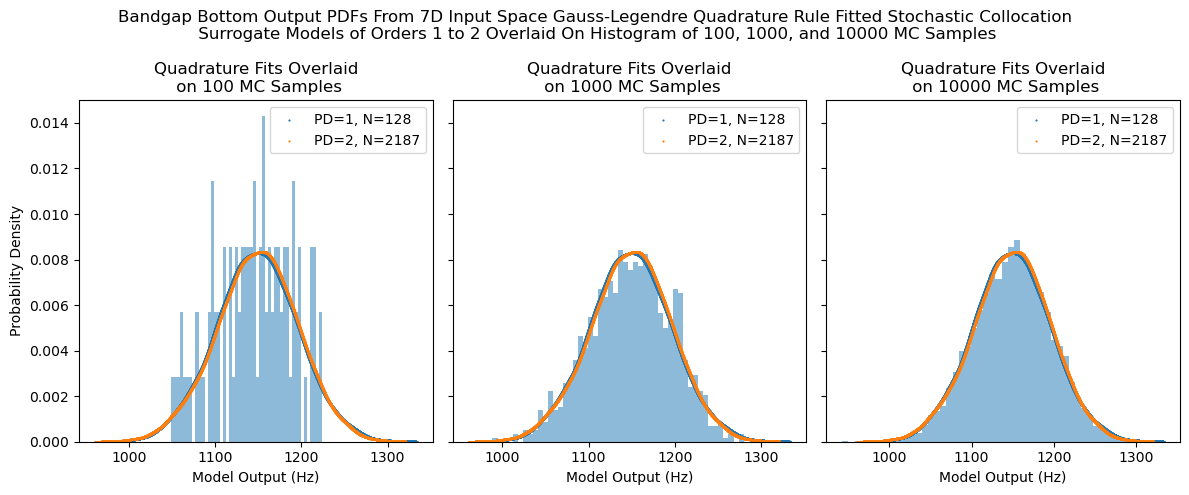

In [39]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), N_test_bgb), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), N_test_bgb), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgb[d]), np.max(surrogate_outputs_bgb[d]), N_test_bgb), surrogate_pdf_bgb[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Quadrature fits on bandgap center

In [40]:
### FIT SURROGATE MODELS - QUADRATURE RULE - BANDGAP CENTER ###
q_surrogates_bgc = {}

for degree in degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist_trunc,
        normed=True
    )
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=quadrature_nodes[degree],
        weights=quadrature_weights[degree],
        solves=bg_center_sample_sets[degree]
    )
    q_surrogates_bgc[degree] = polynomial_approximation

In [41]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_bgc = 10000
joint_test_bgc = joint_dist_trunc.sample(N_test_bgc)
print(joint_test_bgc.shape)
#print(joint_test_bgc[0])
surrogate_outputs_bgc = {}
surrogate_kdes_bgc = {}
surrogate_pdf_bgc = {}
for degree in degrees:
    surrogate_model = q_surrogates_bgc[degree]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs_bgc[degree] = surrogate_model.__call__(joint_test_bgc).astype(float)
    surrogate_outputs_bgc[degree] = surrogate_model(
        q0=joint_test_bgc[0,:], q1=joint_test_bgc[1,:],
        q2=joint_test_bgc[2,:], q3=joint_test_bgc[3,:],
        q4=joint_test_bgc[4,:], q5=joint_test_bgc[5,:], q6=joint_test_bgc[6,:])
    #print(surrogate_outputs_bgc[degree])
    surrogate_kdes_bgc[degree] = gaussian_kde(surrogate_outputs_bgc[degree])
    surrogate_pdf_bgc[degree] = surrogate_kdes_bgc[degree](np.linspace(np.min(surrogate_outputs_bgc[degree]), np.max(surrogate_outputs_bgc[degree]), N_test_bgc))

    # Save surrogate model outputs and KDEs
    save_folder = 'gaussian 6+1 inputs quadrature rule 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_bgc_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_bgc[degree]})
    savemat(save_folder+'/surrogate_kdes_bgc_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': surrogate_kdes_bgc[degree]})


(7, 10000)


Text(0.5, 0.98, 'Bandgap Center Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders 1 to 2 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

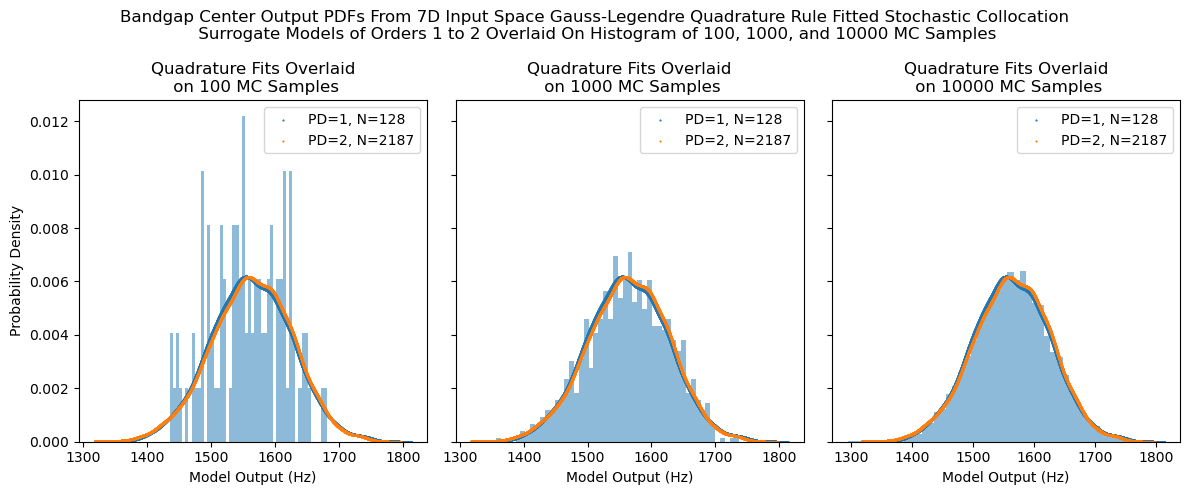

In [42]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in degrees:
    plot_label = 'PD='+str(d)+', N='+str(len(bg_size_sample_sets[d]))#+str((d+1)**7)
    axs[0].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), N_test_bgc), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), N_test_bgc), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(surrogate_outputs_bgc[d]), np.max(surrogate_outputs_bgc[d]), N_test_bgc), surrogate_pdf_bgc[d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('Quadrature Fits Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('Quadrature Fits Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('Quadrature Fits Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From 7D Input Space Gauss-Legendre Quadrature Rule Fitted Stochastic Collocation\n Surrogate Models of Orders '+str(np.min(degrees))+' to '+str(np.max(degrees))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Alternative Graphs

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top, Bottom,\n and Center Locations For 7D Input Space, Gaussian Distributions")

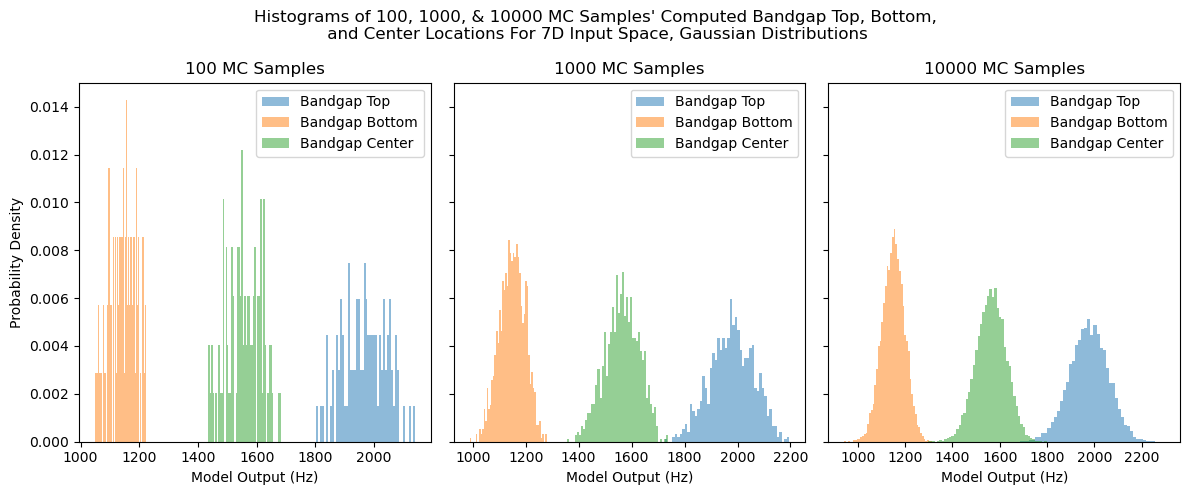

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Center')
# axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
# axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
# axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top, Bottom,\n and Center Locations For 7D Input Space, Gaussian Distributions'
fig.suptitle(title_str)


Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top and Bottom Locations\n and Bandgap Size For 7D Input Space, Gaussian Distributions")

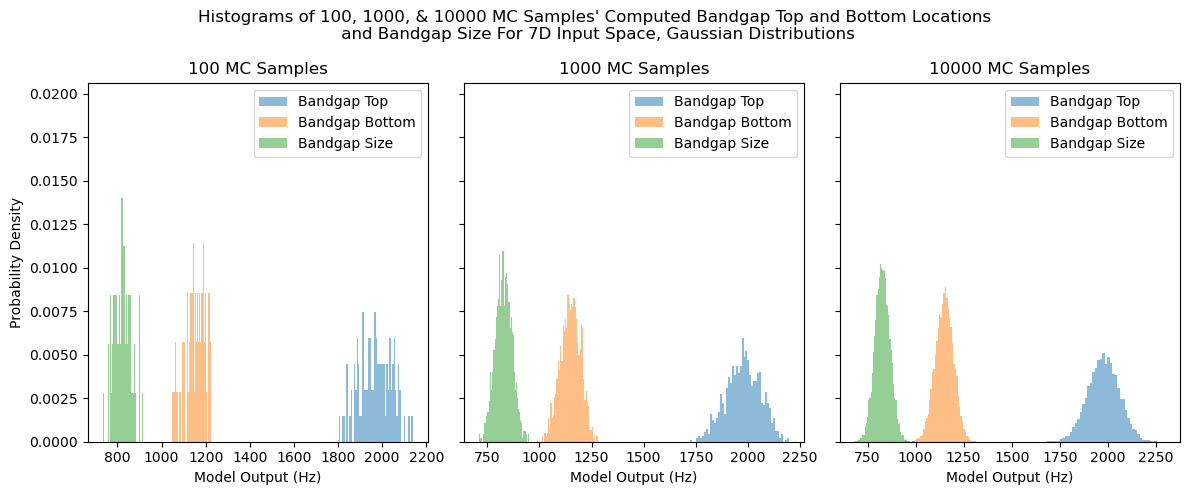

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Size')
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Size')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top and Bottom Locations\n and Bandgap Size For 7D Input Space, Gaussian Distributions'
fig.suptitle(title_str)

Text(0.5, 0.98, "Histograms of 100, 1000, & 10000 MC Samples' Computed Bandgap Top\n and Bottom Locations For 7D Input Space, Gaussian Distributions")

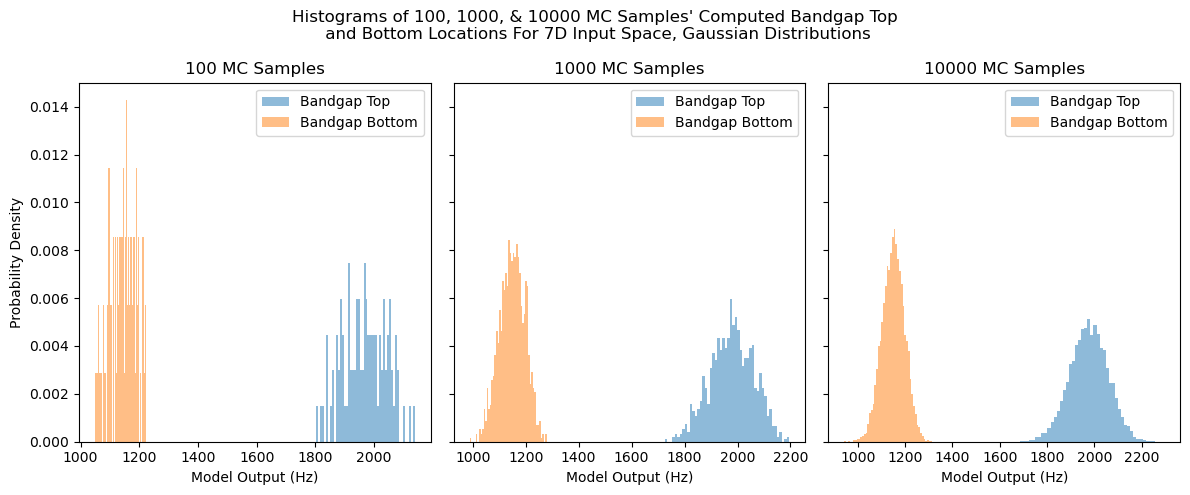

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Top')
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5, label='Bandgap Bottom')

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('10000 MC Samples')

title_str = 'Histograms of 100, 1000, & 10000 MC Samples\' Computed Bandgap Top\n and Bottom Locations For 7D Input Space, Gaussian Distributions'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Size

In [46]:
MC_inputs = {}
# MC_inputs[N_MC2] = joint_samples_MC2
# MC_inputs[N_MC3] = joint_samples_MC3
# MC_inputs[N_MC4] = joint_samples_MC4
for n in set_N:
    MC_inputs[n] = np.hstack((
        E_soft_MC_sets[n],
        E_hard_MC_sets[n],
        rho_soft_MC_sets[n],
        rho_hard_MC_sets[n],
        pr_soft_MC_sets[n],
        pr_hard_MC_sets[n],
        geo_fp_MC_sets[n]
    ))

MC_degrees = {}
MC_degrees[N_MC2] = np.array([1,2,3,4])
MC_degrees[N_MC3] = np.array([1,2,3,4])
MC_degrees[N_MC4] = np.array([1,2,3,4])
print(E_soft_MC_sets[100].shape)
print(MC_inputs[N_MC2].shape)
print(MC_inputs[N_MC3].shape)
print(MC_inputs[N_MC4].shape)
print(type(MC_degrees))
print(type(MC_degrees[N_MC2]))

(100, 1)
(100, 7)
(1000, 7)
(10000, 7)
<class 'dict'>
<class 'numpy.ndarray'>


In [47]:
# r_surrogates_bgs_MC_100 = {}
# for degree in MC_degrees[N_MC2]:
#     polynomial_basis = cp.expansion.stieltjes(
#         order=degree,
#         dist=joint_dist_trunc,
#         normed=True
#     )
#     # print(fit_input.shape)
#     # print(bg_size_MC_sets[100].shape)
#     polynomial_approximation = cp.fit_regression(
#         polynomials=polynomial_basis,
#         abscissas=MC_inputs[N_MC2],
#         evals=bg_size_MC_sets[N_MC2],
#     )
#     r_surrogates_bgs_MC_100[degree] = polynomial_approximation

In [48]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgs = {}
for n in set_N:
    print(n)
    r_surrogates_bgs[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist_trunc,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n].T,
            evals=bg_size_MC_sets[n],
        )
        r_surrogates_bgs[n][degree] = polynomial_approximation

100
1000
10000


In [49]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 10000
joint_test_mc = joint_dist_trunc.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgs[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), N_test_mc))

        # Save surrogate model outputs and KDEs
        save_folder = 'gaussian 6+1 inputs mc 2nd geo study'
        savemat(save_folder+'/surrogate_outputs_bgs_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': mc_surrogate_outputs[n][degree]})
        savemat(save_folder+'/surrogate_kdes_bgs_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': mc_surrogate_kdes[n][degree]})

Text(0.5, 0.98, 'Bandgap Size Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

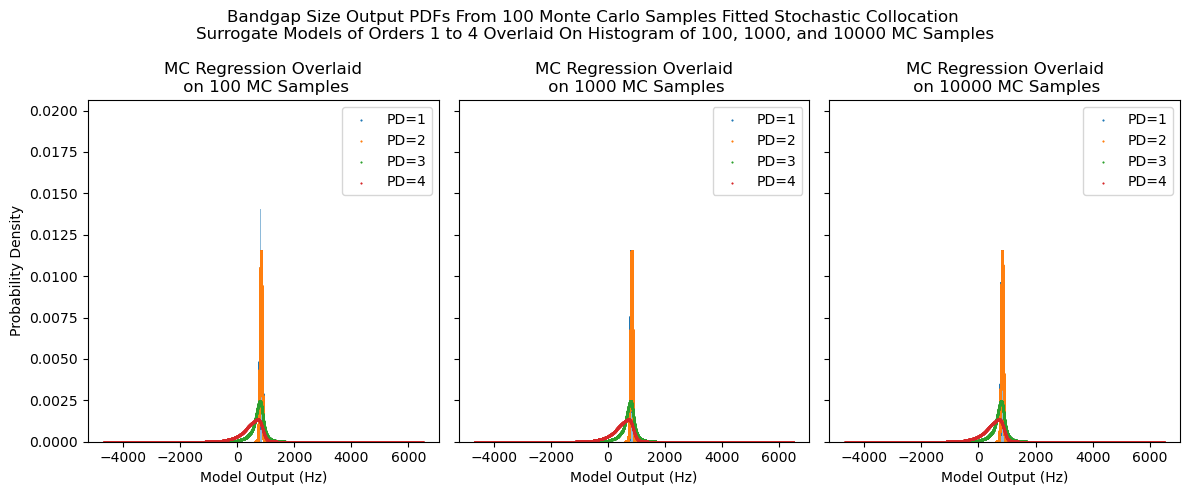

In [50]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From '+str(N_MC2)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Size Output PDFs From 1000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

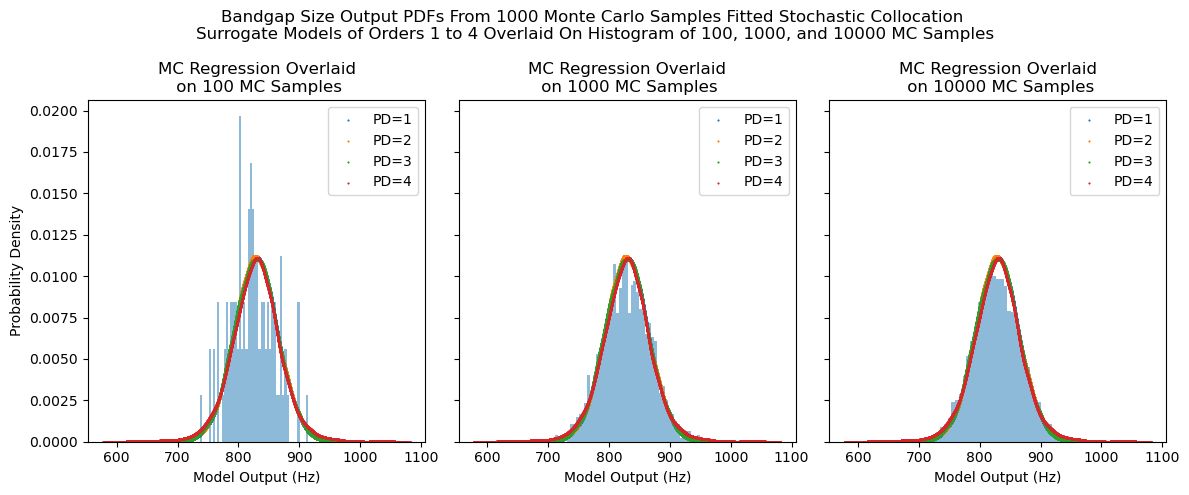

In [51]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From '+str(N_MC3)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Size Output PDFs From 10000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

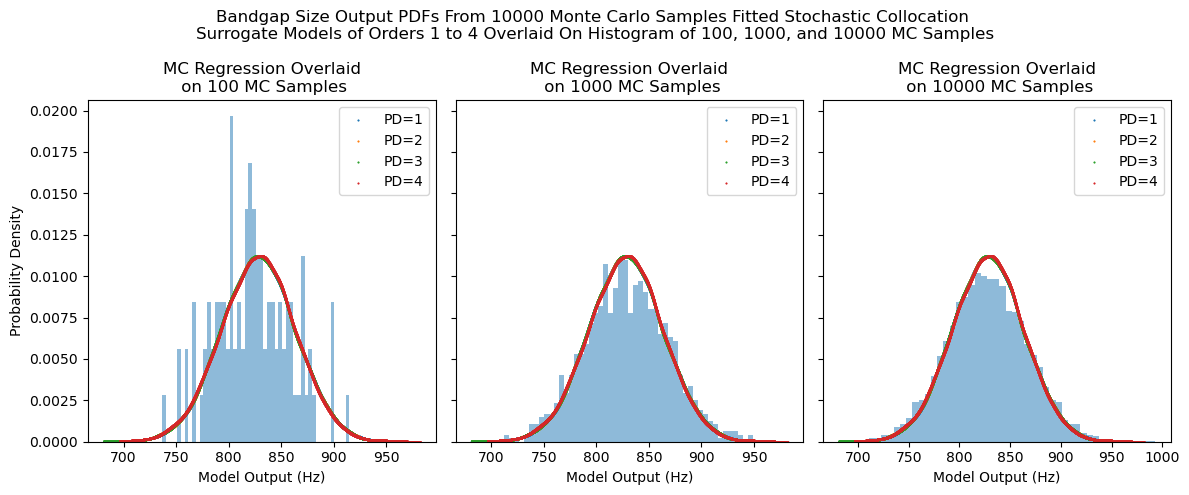

In [52]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_size_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_size_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Size Output PDFs From '+str(N_MC4)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Top

In [53]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgt = {}
for n in set_N:
    print(n)
    r_surrogates_bgt[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist_trunc,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n].T,
            evals=bg_top_MC_sets[n],
        )
        r_surrogates_bgt[n][degree] = polynomial_approximation

100
1000
10000


In [54]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 10000
joint_test_mc = joint_dist_trunc.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgt[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), N_test_mc))

        # Save surrogate model outputs and KDEs
        save_folder = 'gaussian 6+1 inputs mc 2nd geo study'
        savemat(save_folder+'/surrogate_outputs_bgt_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': mc_surrogate_outputs[n][degree]})
        savemat(save_folder+'/surrogate_kdes_bgt_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': mc_surrogate_kdes[n][degree]})

Text(0.5, 0.98, 'Bandgap Top Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

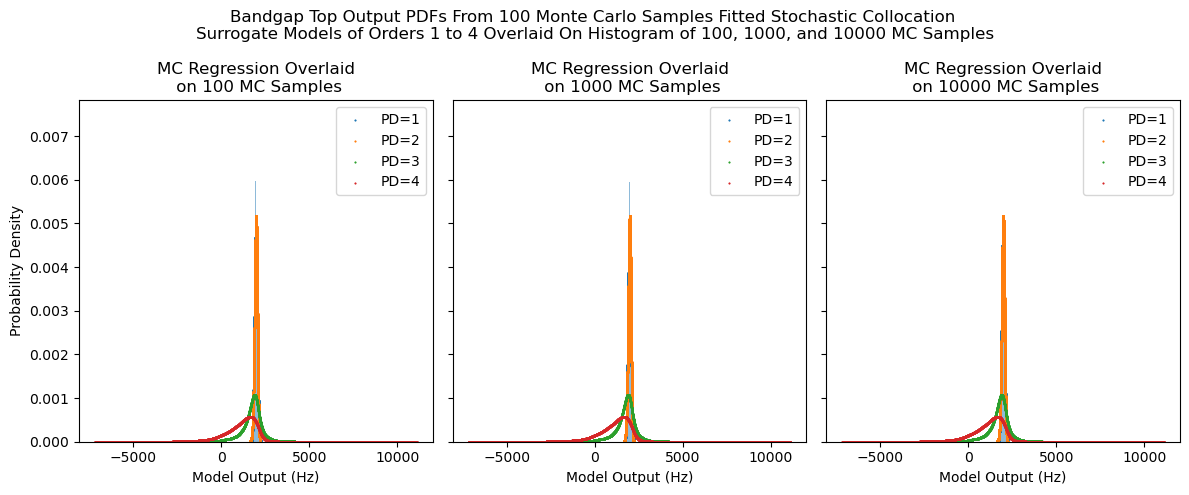

In [55]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From '+str(N_MC2)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Top Output PDFs From 1000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

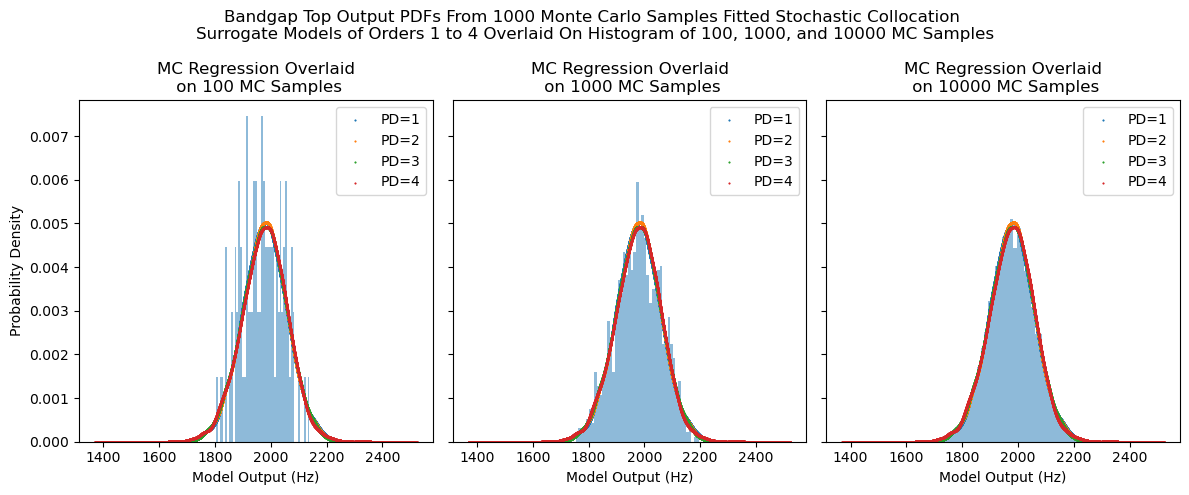

In [56]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From '+str(N_MC3)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Top Output PDFs From 10000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

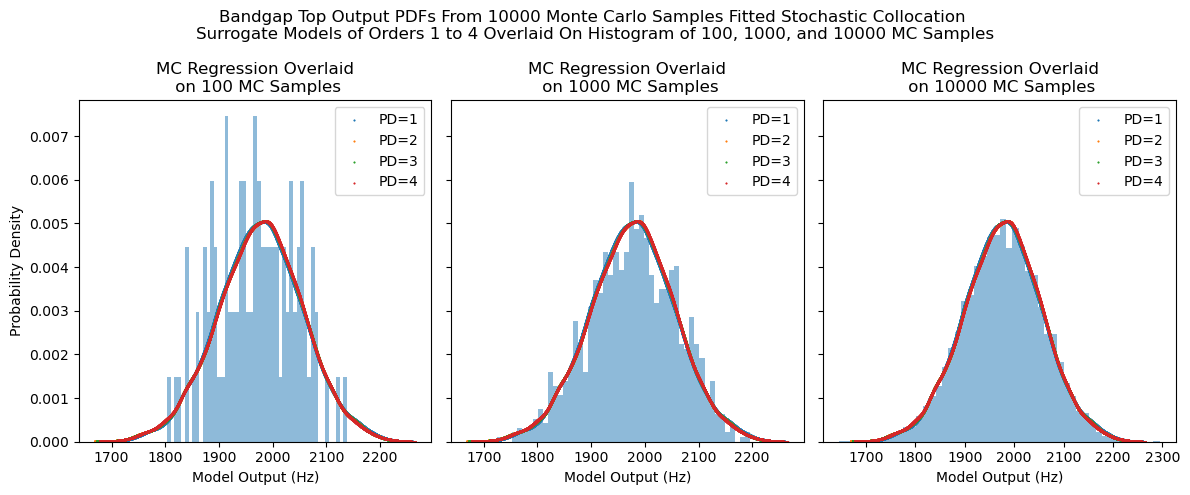

In [57]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_top_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_top_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_top_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Top Output PDFs From '+str(N_MC4)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Bottom


In [58]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgb = {}
for n in set_N:
    print(n)
    r_surrogates_bgb[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist_trunc,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n].T,
            evals=bg_bottom_MC_sets[n],
        )
        r_surrogates_bgb[n][degree] = polynomial_approximation

100
1000
10000


In [59]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 10000
joint_test_mc = joint_dist_trunc.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgb[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), N_test_mc))

        # Save surrogate model outputs and KDEs
        save_folder = 'gaussian 6+1 inputs mc 2nd geo study'
        savemat(save_folder+'/surrogate_outputs_bgb_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': mc_surrogate_outputs[n][degree]})
        savemat(save_folder+'/surrogate_kdes_bgb_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': mc_surrogate_kdes[n][degree]})

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

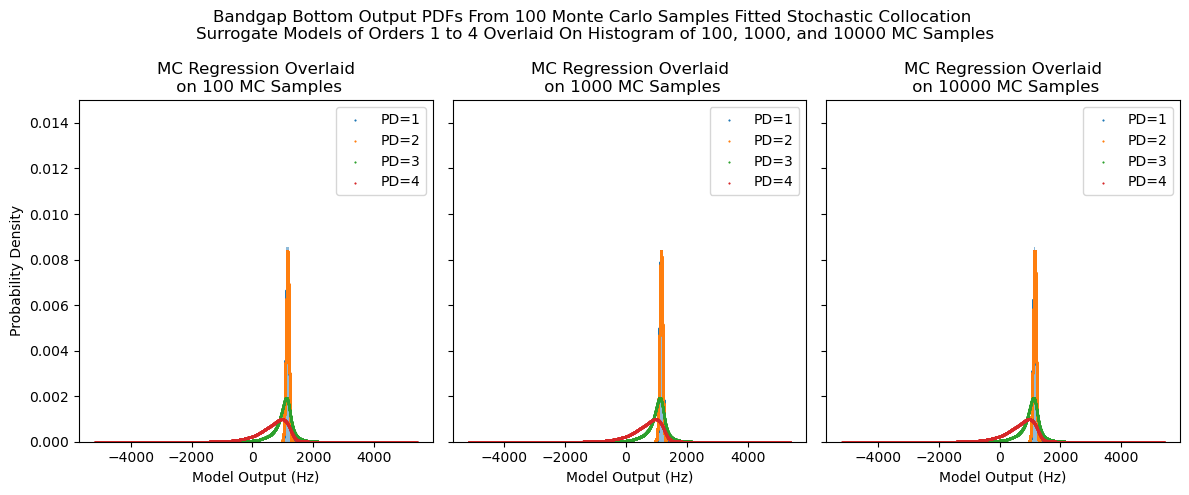

In [60]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From '+str(N_MC2)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From 1000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

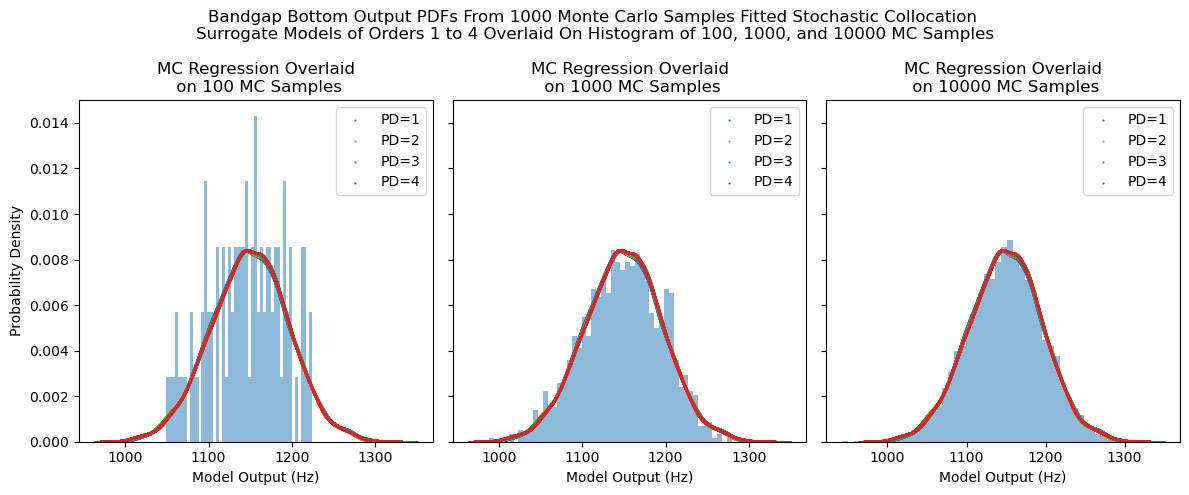

In [61]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From '+str(N_MC3)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Bottom Output PDFs From 10000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

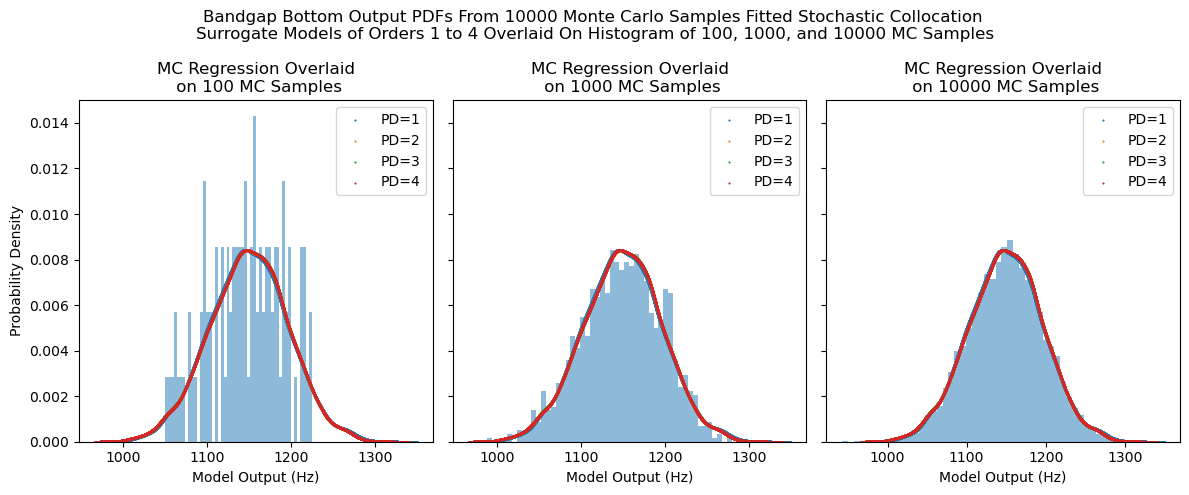

In [62]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_bottom_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_bottom_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_bottom_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Bottom Output PDFs From '+str(N_MC4)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Stochastic Collocation - MC Regression - Bandgap Center

In [63]:
### FIT SURROGATE MODELS - MONTE CARLO REGRESSION ###
r_surrogates_bgc = {}
for n in set_N:
    print(n)
    r_surrogates_bgc[n] = {}
    for degree in MC_degrees[n]:
        polynomial_basis = cp.expansion.stieltjes(
            order=degree,
            dist=joint_dist_trunc,
            normed=True
        )
        # print(bg_size_MC_sets[100].shape)
        polynomial_approximation = cp.fit_regression(
            polynomials=polynomial_basis,
            abscissas=MC_inputs[n].T,
            evals=bg_center_MC_sets[n],
        )
        r_surrogates_bgc[n][degree] = polynomial_approximation

100
1000
10000


In [64]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test_mc = 10000
joint_test_mc = joint_dist_trunc.sample(N_test_mc)
#print(joint_test_mc.shape)
#print(joint_test_mc[0])
mc_surrogate_outputs = {}
mc_surrogate_kdes = {}
mc_surrogate_pdf = {}
for n in set_N:
    mc_surrogate_outputs[n] = {}
    mc_surrogate_kdes[n] = {}
    mc_surrogate_pdf[n] = {}

    for degree in MC_degrees[n]:
        mc_surrogate_model = r_surrogates_bgc[n][degree]
        #print(type(mc_surrogate_model))
        #print(mc_surrogate_model)
        mc_surrogate_outputs[n][degree] = mc_surrogate_model(
            q0=joint_test_mc[0,:], q1=joint_test_mc[1,:],
            q2=joint_test_mc[2,:], q3=joint_test_mc[3,:],
            q4=joint_test_mc[4,:], q5=joint_test_mc[5,:], q6=joint_test_mc[6,:])
        #print(mc_surrogate_outputs[n][degree])
        mc_surrogate_kdes[n][degree] = gaussian_kde(mc_surrogate_outputs[n][degree])
        mc_surrogate_pdf[n][degree] = mc_surrogate_kdes[n][degree](np.linspace(np.min(mc_surrogate_outputs[n][degree]), np.max(mc_surrogate_outputs[n][degree]), N_test_mc))

        # Save surrogate model outputs and KDEs
        save_folder = 'gaussian 6+1 inputs mc 2nd geo study'
        savemat(save_folder+'/surrogate_outputs_bgc_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': mc_surrogate_outputs[n][degree]})
        savemat(save_folder+'/surrogate_kdes_bgc_mc_'+str(n)+'_pd_'+str(degree)+'.mat', {'pd_'+str(degree)+'_kdes': mc_surrogate_kdes[n][degree]})

Text(0.5, 0.98, 'Bandgap Center Output PDFs From 100 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

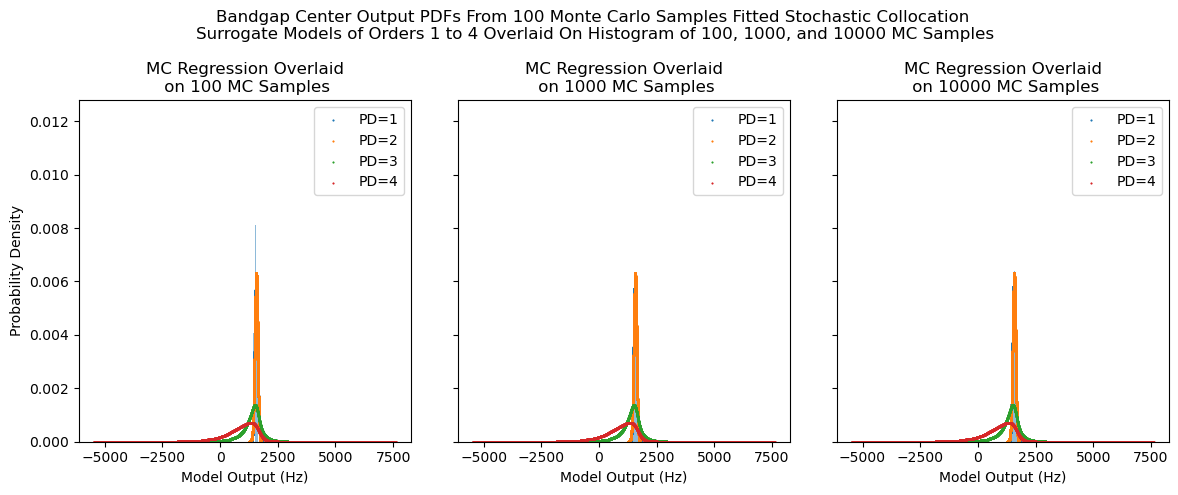

In [65]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC2]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC2][d]), np.max(mc_surrogate_outputs[N_MC2][d]), N_test_mc), mc_surrogate_pdf[N_MC2][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From '+str(N_MC2)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC2]))+' to '+str(np.max(MC_degrees[N_MC2]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Center Output PDFs From 1000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

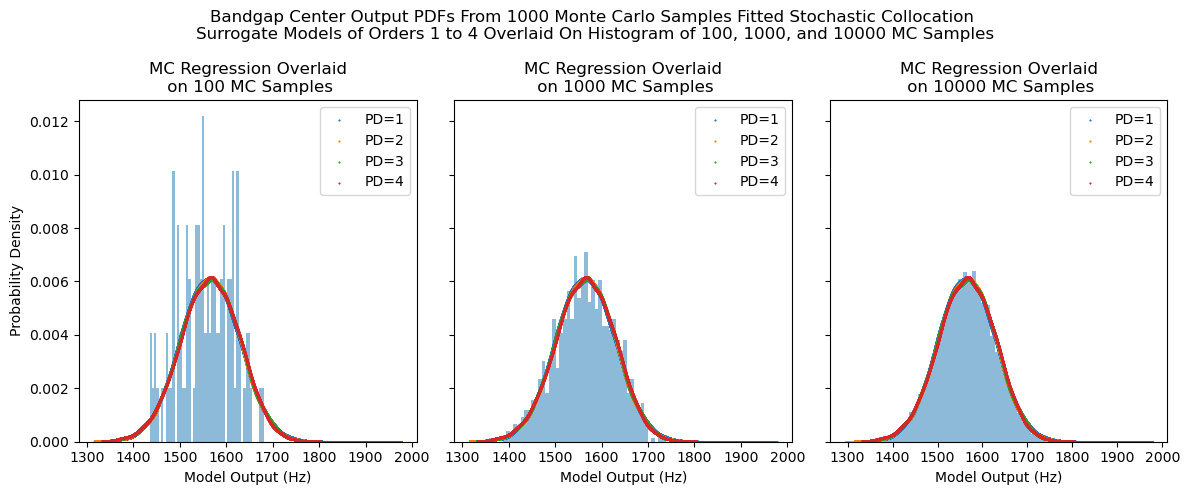

In [66]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC3]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC3][d]), np.max(mc_surrogate_outputs[N_MC3][d]), N_test_mc), mc_surrogate_pdf[N_MC3][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From '+str(N_MC3)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC3]))+' to '+str(np.max(MC_degrees[N_MC3]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

Text(0.5, 0.98, 'Bandgap Center Output PDFs From 10000 Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders 1 to 4 Overlaid On Histogram of 100, 1000, and 10000 MC Samples')

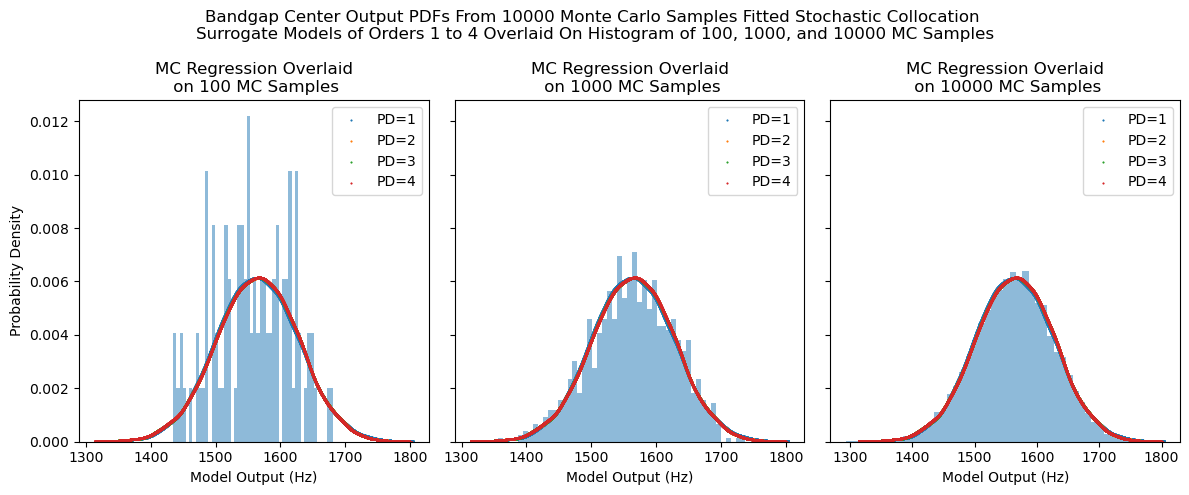

In [67]:
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, tight_layout=True, figsize=(12,5))

# Plot histograms of random samples for comparision with surrogate model
axs[0].hist(bg_center_MC_sets[100], bins=50, density=True, alpha=0.5)
axs[1].hist(bg_center_MC_sets[1000], bins=50, density=True, alpha=0.5)
axs[2].hist(bg_center_MC_sets[10000], bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for d in MC_degrees[N_MC4]:
    plot_label = 'PD='+str(d)
    axs[0].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[1].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)
    axs[2].scatter(np.linspace(np.min(mc_surrogate_outputs[N_MC4][d]), np.max(mc_surrogate_outputs[N_MC4][d]), N_test_mc), mc_surrogate_pdf[N_MC4][d], label=plot_label, s=1, linewidths=0.5)

axs[0].set_xlabel("Model Output (Hz)")
axs[0].set_ylabel("Probability Density")
axs[0].legend(loc='best')
axs[0].set_title('MC Regression Overlaid\n on 100 MC Samples')

axs[1].set_xlabel("Model Output (Hz)")
#axs[1].set_ylabel("Probability Density")
axs[1].legend(loc='best')
axs[1].set_title('MC Regression Overlaid\n on 1000 MC Samples')

axs[2].set_xlabel("Model Output (Hz)")
#axs[2].set_ylabel("Probability Density")
axs[2].legend(loc='best')
axs[2].set_title('MC Regression Overlaid\n on 10000 MC Samples')

title_str = 'Bandgap Center Output PDFs From '+str(N_MC4)+' Monte Carlo Samples Fitted Stochastic Collocation \nSurrogate Models of Orders '+str(np.min(MC_degrees[N_MC4]))+' to '+str(np.max(MC_degrees[N_MC4]))+' Overlaid On Histogram of 100, 1000, and 10000 MC Samples'
fig.suptitle(title_str)

2D HISTOGRAMS (BANDGAP SIZE & CENTER)

In [68]:
print(degrees)
print(MC_degrees[1000])
intersection_degrees = np.intersect1d(degrees, MC_degrees[1000])
print(intersection_degrees)

[1, 2]
[1 2 3 4]
[1 2]


In [69]:
#joint_output_dist = cp.J(bg_size_dist, bg_center_dist)
N_test_4 = 10**4
joint_test_4 = joint_dist_trunc.sample(N_test_4)
surrogate_outputs_q_bgs = {}
surrogate_outputs_q_bgc = {}
surrogate_outputs_r_bgs = {}
surrogate_outputs_r_bgc = {}
surrogate_outputs_sg_bgc = {}
surrogate_outputs_sg_bgc = {}

for degree in intersection_degrees:
    surrogate_model_q_bgs = q_surrogates_bgs[degree]
    surrogate_outputs_q_bgs[degree] = surrogate_model_q_bgs(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_q_bgc = q_surrogates_bgc[degree]
    surrogate_outputs_q_bgc[degree] = surrogate_model_q_bgc(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    #save quadrature rule surrogate outputs
    save_folder = 'gaussian 6+1 inputs quadrature rule 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_2d_q_bgs_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_q_bgs[degree]})
    savemat(save_folder+'/surrogate_outputs_2d_q_bgc_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_q_bgc[degree]})

    surrogate_model_r_bgs = r_surrogates_bgs[N_MC3][degree]
    surrogate_outputs_r_bgs[degree] = surrogate_model_r_bgs(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_r_bgc = r_surrogates_bgc[N_MC3][degree]
    surrogate_outputs_r_bgc[degree] = surrogate_model_r_bgc(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    #save MC regression surrogate outputs
    save_folder = 'gaussian 6+1 inputs mc 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_2d_r_bgs_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_r_bgs[degree]})
    savemat(save_folder+'/surrogate_outputs_2d_r_bgc_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_r_bgc[degree]})

sparse_degrees = [1]
for degree in sparse_degrees:
    surrogate_model_sg_bgs = sg_surrogates_bgs[degree]
    surrogate_outputs_sg_bgs[degree] = surrogate_model_sg_bgs(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    surrogate_model_sg_bgc = sg_surrogates_bgc[degree]
    surrogate_outputs_sg_bgc[degree] = surrogate_model_sg_bgc(
        q0=joint_test_4[0,:], q1=joint_test_4[1,:],
        q2=joint_test_4[2,:], q3=joint_test_4[3,:],
        q4=joint_test_4[4,:], q5=joint_test_4[5,:], q6=joint_test_4[6,:])

    #save sparse grid surrogate outputs
    save_folder = 'gaussian 6+1 inputs sparse grid 2nd geo study'
    savemat(save_folder+'/surrogate_outputs_2d_sg_bgs_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgs[degree]})
    savemat(save_folder+'/surrogate_outputs_2d_sg_bgc_'+str(degree)+'.mat', {'pd_'+str(degree)+'_outputs': surrogate_outputs_sg_bgc[degree]})
print(surrogate_outputs_q_bgs.keys())

dict_keys([1, 2])


(array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 1.,  1., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  1., nan, nan],
       [nan, nan, nan, ..., nan, nan,  1.]]), array([685.99815738, 692.13781305, 698.27746872, 704.4171244 ,
       710.55678007, 716.69643574, 722.83609142, 728.97574709,
       735.11540276, 741.25505844, 747.39471411, 753.53436978,
       759.67402545, 765.81368113, 771.9533368 , 778.09299247,
       784.23264815, 790.37230382, 796.51195949, 802.65161516,
       808.79127084, 814.93092651, 821.07058218, 827.21023786,
       833.34989353, 839.4895492 , 845.62920488, 851.76886055,
       857.90851622, 864.04817189, 870.18782757, 876.32748324,
       882.46713891, 888.60679459, 894.74645026, 900.88610593,
       907.0257616 , 913.16541728, 919.30507295, 925.44472862,
       931.5843843 , 937.72403997, 943.86369564, 950.00335131,
       956.14300699, 962.282

Text(0.5, 0.98, '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model')

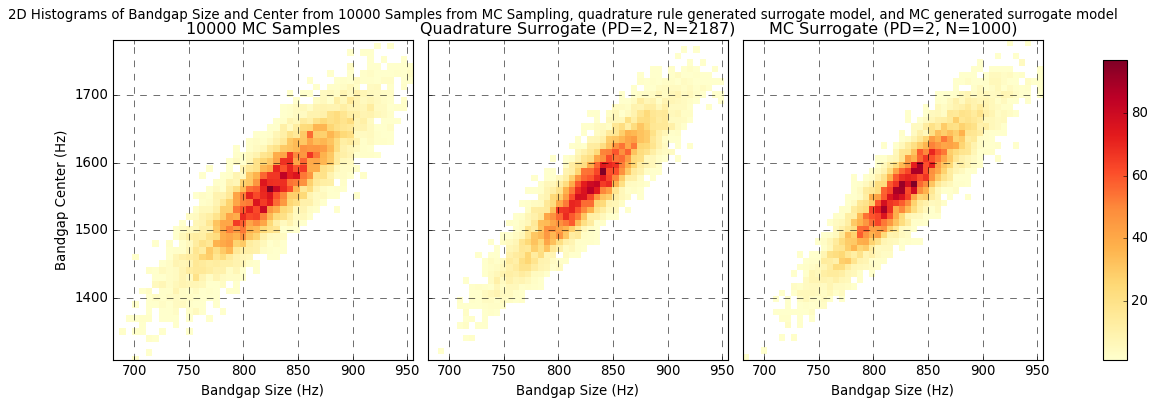

In [70]:
plt.style.use('classic')
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
pd = 2
hist_mc_samples = axs[0].hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_q_gen = axs[1].hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_mc_gen = axs[2].hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)

print(hist_mc_samples)
axs[0].set_xlabel("Bandgap Size (Hz)")
axs[0].set_ylabel("Bandgap Center (Hz)")
axs[0].set_title('10000 MC Samples')
#axs[0].set_aspect('equal')

axs[1].set_xlabel("Bandgap Size (Hz)")
#axs[1].set_ylabel("Bandgap Center (Hz)")
axs[1].set_title('Quadrature Surrogate (PD='+str(pd)+', N='+str(len(bg_size_sample_sets[pd].flatten()))+')')
#axs[1].set_aspect('equal')

axs[2].set_xlabel("Bandgap Size (Hz)")
#axs[2].set_ylabel("Bandgap Center (Hz)")
axs[2].set_title('MC Surrogate (PD='+str(pd)+', N='+str(len(bg_size_MC_sets[1000].flatten()))+')')
#axs[2].set_aspect('equal')

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
fig.colorbar(hist_mc_gen[3], cax=cbar_ax)
plt.subplots_adjust(wspace=0.05)

axs[0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1].grid(which='both', linestyle='--', linewidth=0.5)
axs[2].grid(which='both', linestyle='--', linewidth=0.5)
fig.set_facecolor('white')
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')
axs[2].set_facecolor('white')

title_str = '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model'
fig.suptitle(title_str)

Text(0.5, 0.98, '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model')

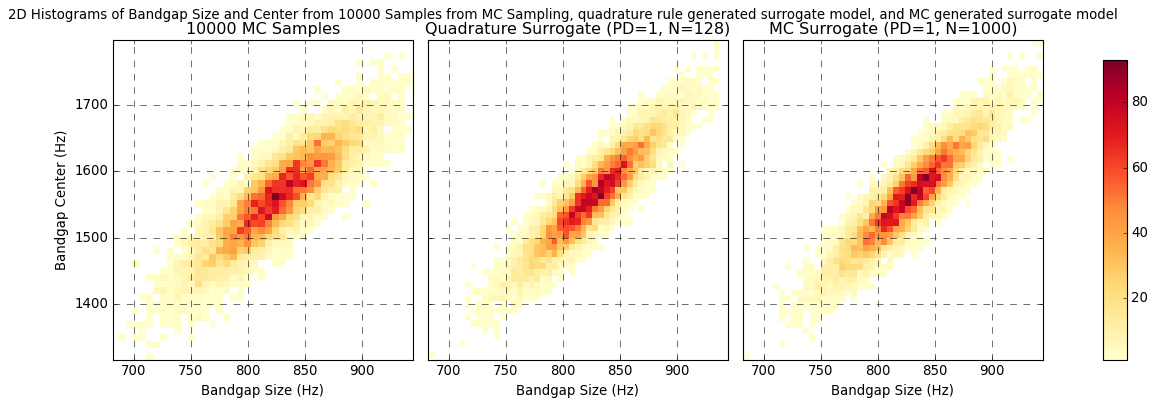

In [71]:
plt.style.use('classic')
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
pd = 1
hist_mc_samples = axs[0].hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_q_gen = axs[1].hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_mc_gen = axs[2].hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)

axs[0].set_xlabel("Bandgap Size (Hz)")
axs[0].set_ylabel("Bandgap Center (Hz)")
axs[0].set_title('10000 MC Samples')
#axs[0].set_aspect('equal')

axs[1].set_xlabel("Bandgap Size (Hz)")
#axs[1].set_ylabel("Bandgap Center (Hz)")
axs[1].set_title('Quadrature Surrogate (PD='+str(pd)+', N='+str(len(bg_size_sample_sets[pd].flatten()))+')')
#axs[1].set_aspect('equal')

axs[2].set_xlabel("Bandgap Size (Hz)")
#axs[2].set_ylabel("Bandgap Center (Hz)")
axs[2].set_title('MC Surrogate (PD='+str(pd)+', N='+str(len(bg_size_MC_sets[1000].flatten()))+')')
#axs[2].set_aspect('equal')

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
fig.colorbar(hist_mc_gen[3], cax=cbar_ax)
plt.subplots_adjust(wspace=0.05)

axs[0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1].grid(which='both', linestyle='--', linewidth=0.5)
axs[2].grid(which='both', linestyle='--', linewidth=0.5)
fig.set_facecolor('white')
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')
axs[2].set_facecolor('white')

title_str = '2D Histograms of Bandgap Size and Center from 10000 Samples from MC Sampling, quadrature rule generated surrogate model, and MC generated surrogate model'
fig.suptitle(title_str)

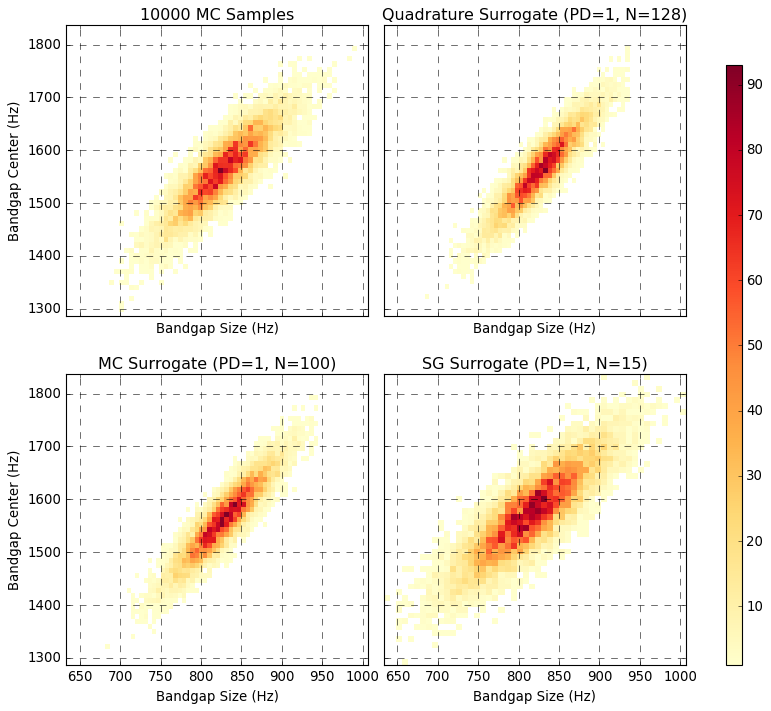

In [72]:
plt.style.use('classic')

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

pd = 1
n = 100

hist_mc_samples = axs[0, 0].hist2d(bg_size_MC_sets[10000].flatten(), bg_center_MC_sets[10000].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_q_gen = axs[0, 1].hist2d(surrogate_outputs_q_bgs[pd].flatten(), surrogate_outputs_q_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_mc_gen = axs[1, 0].hist2d(surrogate_outputs_r_bgs[pd].flatten(), surrogate_outputs_r_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)
hist_sg_gen = axs[1, 1].hist2d(surrogate_outputs_sg_bgs[pd].flatten(), surrogate_outputs_sg_bgc[pd].flatten(), bins=(50, 50), cmap='YlOrRd', cmin=0.5)

axs[0, 0].set_xlabel("Bandgap Size (Hz)")
axs[0, 0].set_ylabel("Bandgap Center (Hz)")
axs[0, 0].set_title('10000 MC Samples')

axs[0, 1].set_xlabel("Bandgap Size (Hz)")
axs[0, 1].set_title('Quadrature Surrogate (PD='+str(pd)+', N='+str(len(bg_size_sample_sets[pd].flatten()))+')')

axs[1, 0].set_ylabel("Bandgap Center (Hz)")
axs[1, 0].set_xlabel("Bandgap Size (Hz)")
axs[1, 0].set_title('MC Surrogate (PD='+str(pd)+', N='+str(len(bg_size_MC_sets[n].flatten()))+')')

axs[1, 1].set_xlabel("Bandgap Size (Hz)")
axs[1, 1].set_title('SG Surrogate (PD='+str(pd)+', N='+str(len(bg_size_SG_sets[pd].flatten()))+')')

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(hist_mc_gen[3], cax=cbar_ax)
cbar.locator = ticker.MultipleLocator(base=10)
cbar.update_ticks()
plt.subplots_adjust(wspace=0.05)

axs[0, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0, 1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 1].grid(which='both', linestyle='--', linewidth=0.5)

fig.set_facecolor('white')
axs[0, 0].set_facecolor('white')
axs[0, 1].set_facecolor('white')
axs[1, 0].set_facecolor('white')
axs[1, 1].set_facecolor('white')

# title_str = '2D Histograms of Bandgap Size and Center of 10000 Samples from Monte Carlo sampling,\n compared with PCE fitted surrogate models from quadrature rule generated samples, \nMonte Carlo generated samples, and sparse grid generated samples'
# fig.suptitle(title_str)#, fontsize=16)